In [1]:
from astropy.table import Table

import numpy as np

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from dark_matter_mass_v1 import rot_fit_BB

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

# Data

In [3]:
#data_filename = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_noWords_v5.txt'
data_filename = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_v6.txt'

data = Table.read(data_filename, format='ascii.commented_header')

In [5]:
################################################################################
# Calculate the velocity at R90, Rmax
#-------------------------------------------------------------------------------
# Convert r from arcsec to kpc
#-------------------------------------------------------------------------------
dist_to_galaxy_Mpc = c*data['NSA_redshift']/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

data['R90_kpc'] = dist_to_galaxy_kpc*np.tan(data['NSA_elpetro_th90']*(1./60)*(1./60)*(np.pi/180))
#-------------------------------------------------------------------------------

data['V90_kms'] = rot_fit_BB(data['R90_kpc'], 
                             [data['Vmax_map'], 
                              data['Rturn_map'], 
                              data['alpha_map']])

data['VRmax_kms'] = rot_fit_BB(data['Rmax_map'], 
                               [data['Vmax_map'], 
                                data['Rturn_map'], 
                                data['alpha_map']])
################################################################################

/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


### Calculate mass ratios

In [6]:
data['M90_Mdisk_ratio'] = 10**(data['M90_map'] - data['M90_disk_map'])

data['M90_MdiskHI_ratio'] = 10**data['M90_map']/(10**data['M90_disk_map'] + 10**data['logHI'])

data['M90_vis'] = np.log10(10**data['M90_disk_map'] + 10**data['logHI'])

In [7]:
bad_boolean = np.logical_or.reduce([np.isnan(data['M90_map']), 
                                    np.isnan(data['M90_disk_map']), 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998, 
                                    data['V90_kms']/data['Vmax_map'] < 0.9, 
                                    (data['Tidal'] & (data['DL_merge'] > 0.97)), 
                                    data['map_frac_unmasked'] < 0.05, 
                                    (data['map_frac_unmasked'] > 0.13) & (data['DRP_map_smoothness'] > 1.96), 
                                    (data['map_frac_unmasked'] > 0.07) & (data['DRP_map_smoothness'] > 2.9), 
                                    (data['map_frac_unmasked'] > -0.0638*data['DRP_map_smoothness'] + 0.255) & (data['DRP_map_smoothness'] > 1.96), 
                                    data['M90_Mdisk_ratio'] > 1050])

good_galaxies = data[~bad_boolean]

'''
bad_boolean = np.logical_or.reduce([data['M90_map'] == -99, 
                                    data['M90_disk_map'] == -99, 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998])

good_galaxies = data[~bad_boolean]
'''
print(len(good_galaxies))

1988


In [8]:
good_galaxies[:10]

<Table length=10>
MaNGA_plate MaNGA_IFU NSA_plate ... M90_MdiskHI_ratio       M90_vis      
   int64      int64     int64   ...      float64            float64      
----------- --------- --------- ... ------------------ ------------------
       8465      1901      1281 ...  9.370251187734311 10.270850556238864
       8249      3702       899 ... 0.5526932673724017 10.174778419165506
       9027      9101      1420 ... 1.7171492983784908  10.31818514955382
       8247     12705      1200 ...  6.689524536494902 10.195344267160051
       9027     12703      1420 ... 20.032635933217133  10.64561005552243
       9027      3701      1420 ...                nan                nan
       8458      6104      2956 ... 11.937699236279075 10.243614890687128
       8993      6102      1434 ...  4.814740586125406  9.636356518793127
       8456      9101       943 ... 2.3115974087200875 10.233913011522139
       8458     12705       941 ...                nan                nan

### Pull out those objects with HI observations

In [9]:
#HI_boolean = np.logical_or(good_galaxies['logHI'] == -99, good_galaxies['logHI'] == -999)
HI_boolean = np.logical_or(np.isnan(good_galaxies['logHI']), 
                           good_galaxies['logHI'] == -999)

goodHI_galaxies = good_galaxies[~HI_boolean]

print(len(goodHI_galaxies))

844


### Separate by CMD classification

In [10]:
BC_boolean = good_galaxies['CMD_class'] == 1
GV_boolean = good_galaxies['CMD_class'] == 2
RS_boolean = good_galaxies['CMD_class'] == 3

BC = good_galaxies[BC_boolean]
GV = good_galaxies[GV_boolean]
RS = good_galaxies[RS_boolean]

print('Blue cloud:', len(BC), np.sum(BC['M90_Mdisk_ratio'] < 20))
print('Green valley:', len(GV), np.sum(GV['M90_Mdisk_ratio'] < 20))
print('Red sequence:', len(RS), np.sum(RS['M90_Mdisk_ratio'] < 20))

Blue cloud: 928 818
Green valley: 492 423
Red sequence: 388 319


In [11]:
BC_HI_boolean = goodHI_galaxies['CMD_class'] == 1
GV_HI_boolean = goodHI_galaxies['CMD_class'] == 2
RS_HI_boolean = goodHI_galaxies['CMD_class'] == 3

BC_HI = goodHI_galaxies[BC_HI_boolean]
GV_HI = goodHI_galaxies[GV_HI_boolean]
RS_HI = goodHI_galaxies[RS_HI_boolean]

print('Blue cloud:', len(BC_HI))
print('Green valley:', len(GV_HI))
print('Red sequence:', len(RS_HI))

Blue cloud: 528
Green valley: 151
Red sequence: 76


### Separate by BPT classification

In [12]:
SF_boolean = (good_galaxies['BPT'] == 1) | (good_galaxies['BPT'] == 4)
comp_boolean = good_galaxies['BPT'] == 2
AGN_boolean = (good_galaxies['BPT'] == 3) | (good_galaxies['BPT'] == 5)

SF = good_galaxies[SF_boolean]
comp = good_galaxies[comp_boolean]
AGN = good_galaxies[AGN_boolean]

In [13]:
SF_HI_boolean = (goodHI_galaxies['BPT'] == 1) | (goodHI_galaxies['BPT'] == 4)
comp_HI_boolean = goodHI_galaxies['BPT'] == 2
AGN_HI_boolean = (goodHI_galaxies['BPT'] == 3) | (goodHI_galaxies['BPT'] == 5)

SF_HI = goodHI_galaxies[SF_HI_boolean]
comp_HI = goodHI_galaxies[comp_HI_boolean]
AGN_HI = goodHI_galaxies[AGN_HI_boolean]

# Sample stats
## Median values

In [14]:
print('Blue cloud:', np.median(BC['M90_Mdisk_ratio']))
print('Green valley:', np.median(GV['M90_Mdisk_ratio']))
print('Red sequence:', np.median(RS['M90_Mdisk_ratio']))

Blue cloud: 4.1700734323113675
Green valley: 3.4374045206324633
Red sequence: 5.03350658762278


In [15]:
print('Blue cloud:', np.median(BC_HI['M90_MdiskHI_ratio']))
print('Green valley:', np.median(GV_HI['M90_MdiskHI_ratio']))
print('Red sequence:', np.median(RS_HI['M90_MdiskHI_ratio']))

Blue cloud: 2.515457290238193
Green valley: 2.1500720006043514
Red sequence: 3.0010730431064028


# Distribution over $R_\text{max}$ and $R_{90}$

<IPython.core.display.Javascript object>


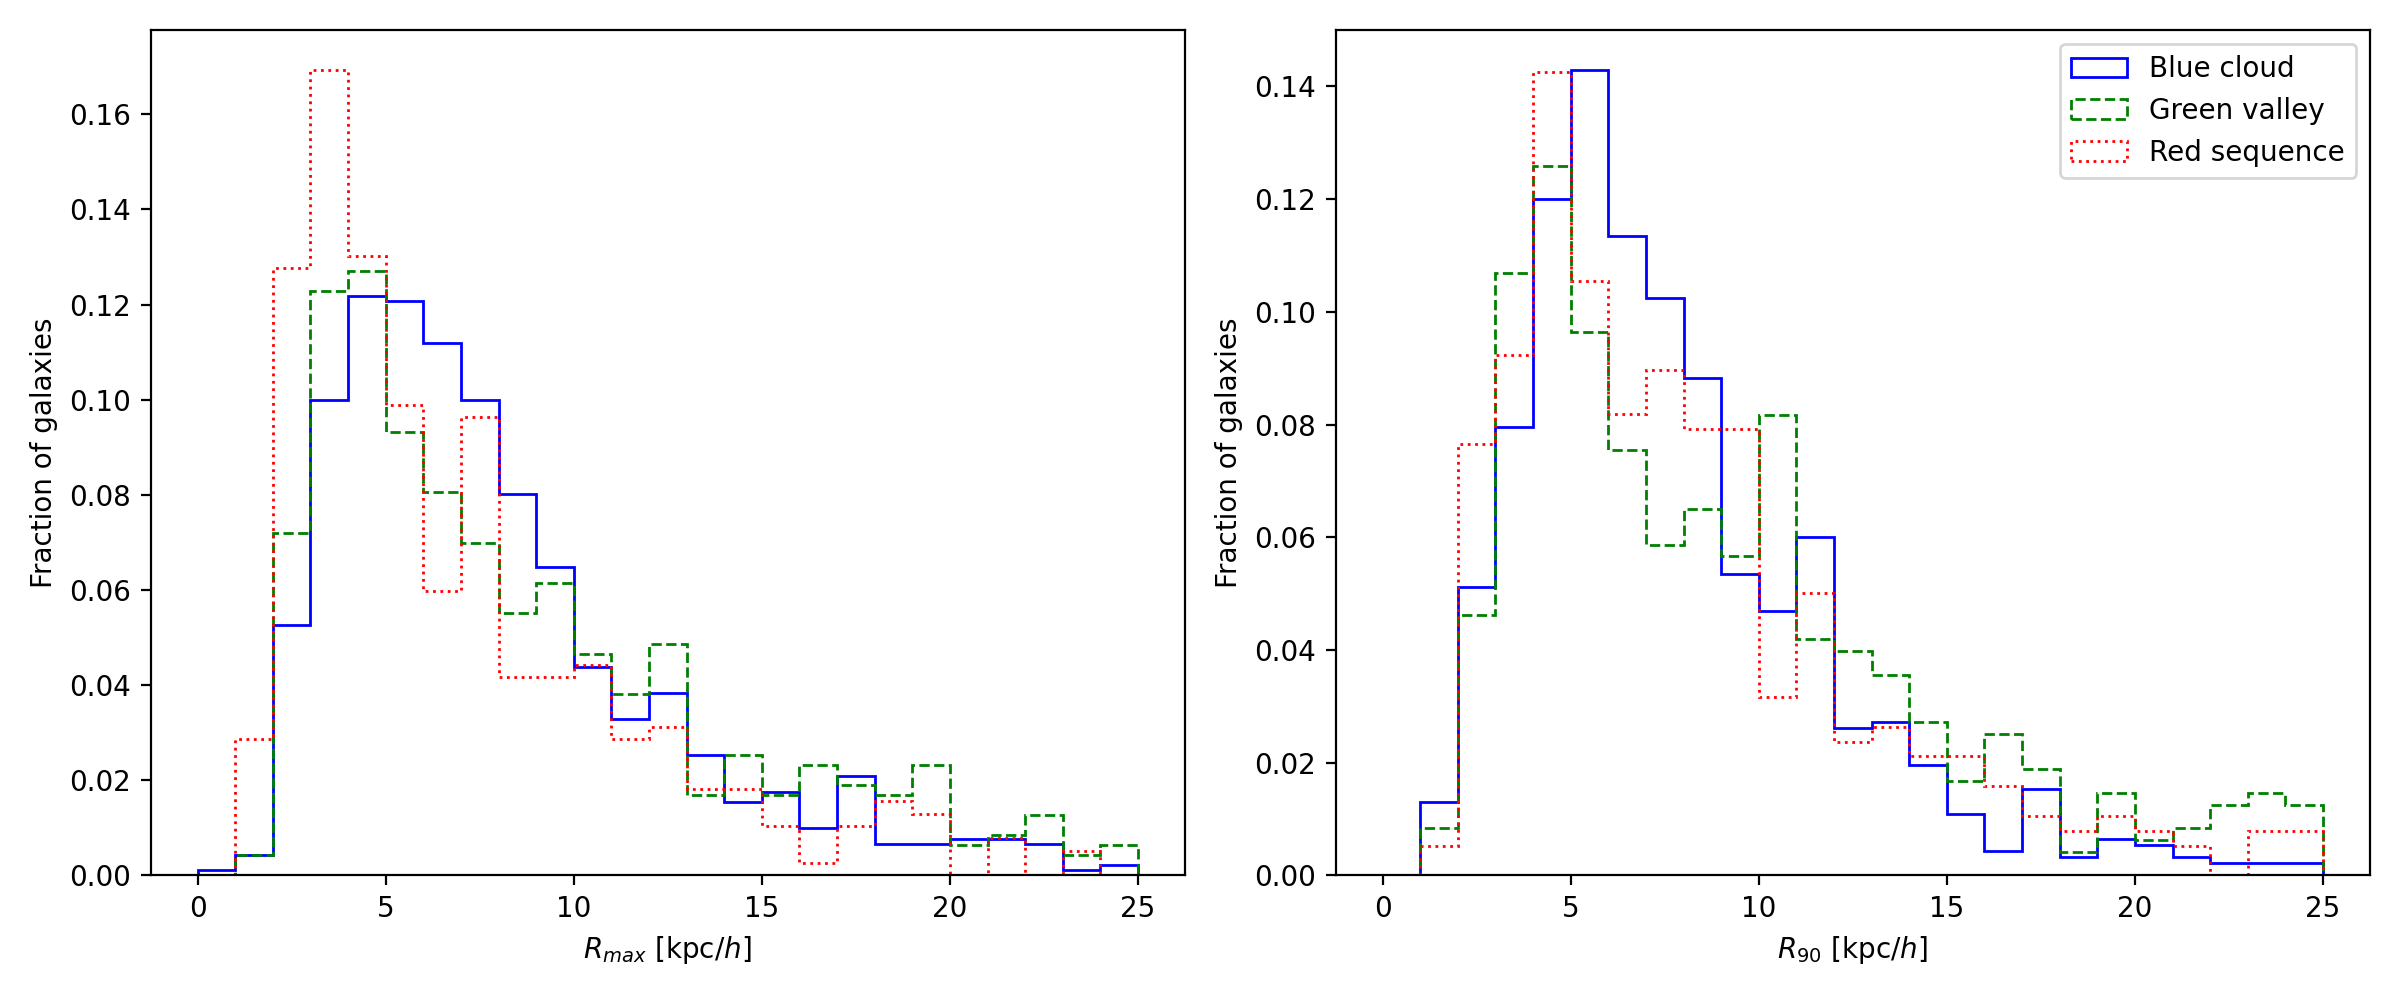

In [16]:
Rmax_bins = np.arange(0,26,1)

plt.figure(figsize=(12,5))



plt.subplot(121)

plt.hist(BC['Rmax_map'], 
         bins=Rmax_bins, 
         density=True, 
         histtype='step', 
         color='b', 
         label='Blue cloud')
plt.hist(GV['Rmax_map'], 
         bins=Rmax_bins, 
         density=True, 
         histtype='step', 
         color='g', 
         linestyle='--', 
         label='Green valley')
plt.hist(RS['Rmax_map'], 
         bins=Rmax_bins, 
         density=True, 
         histtype='step', 
         color='r', 
         linestyle=':', 
         label='Red sequence')

plt.xlabel('$R_{max}$ [kpc/$h$]')
plt.ylabel('Fraction of galaxies')



plt.subplot(122)

plt.hist(BC['R90_kpc'], bins=Rmax_bins, density=True, histtype='step', color='b', label='Blue cloud')
plt.hist(GV['R90_kpc'], bins=Rmax_bins, density=True, histtype='step', color='g', linestyle='--', label='Green valley')
plt.hist(RS['R90_kpc'], bins=Rmax_bins, density=True, histtype='step', color='r', linestyle=':', label='Red sequence')

plt.xlabel('$R_{90}$ [kpc/$h$]')
plt.ylabel('Fraction of galaxies')

plt.legend()

plt.tight_layout();

# Sample rotation curves

In [17]:
radii_max = np.linspace(0,1,100)

<IPython.core.display.Javascript object>


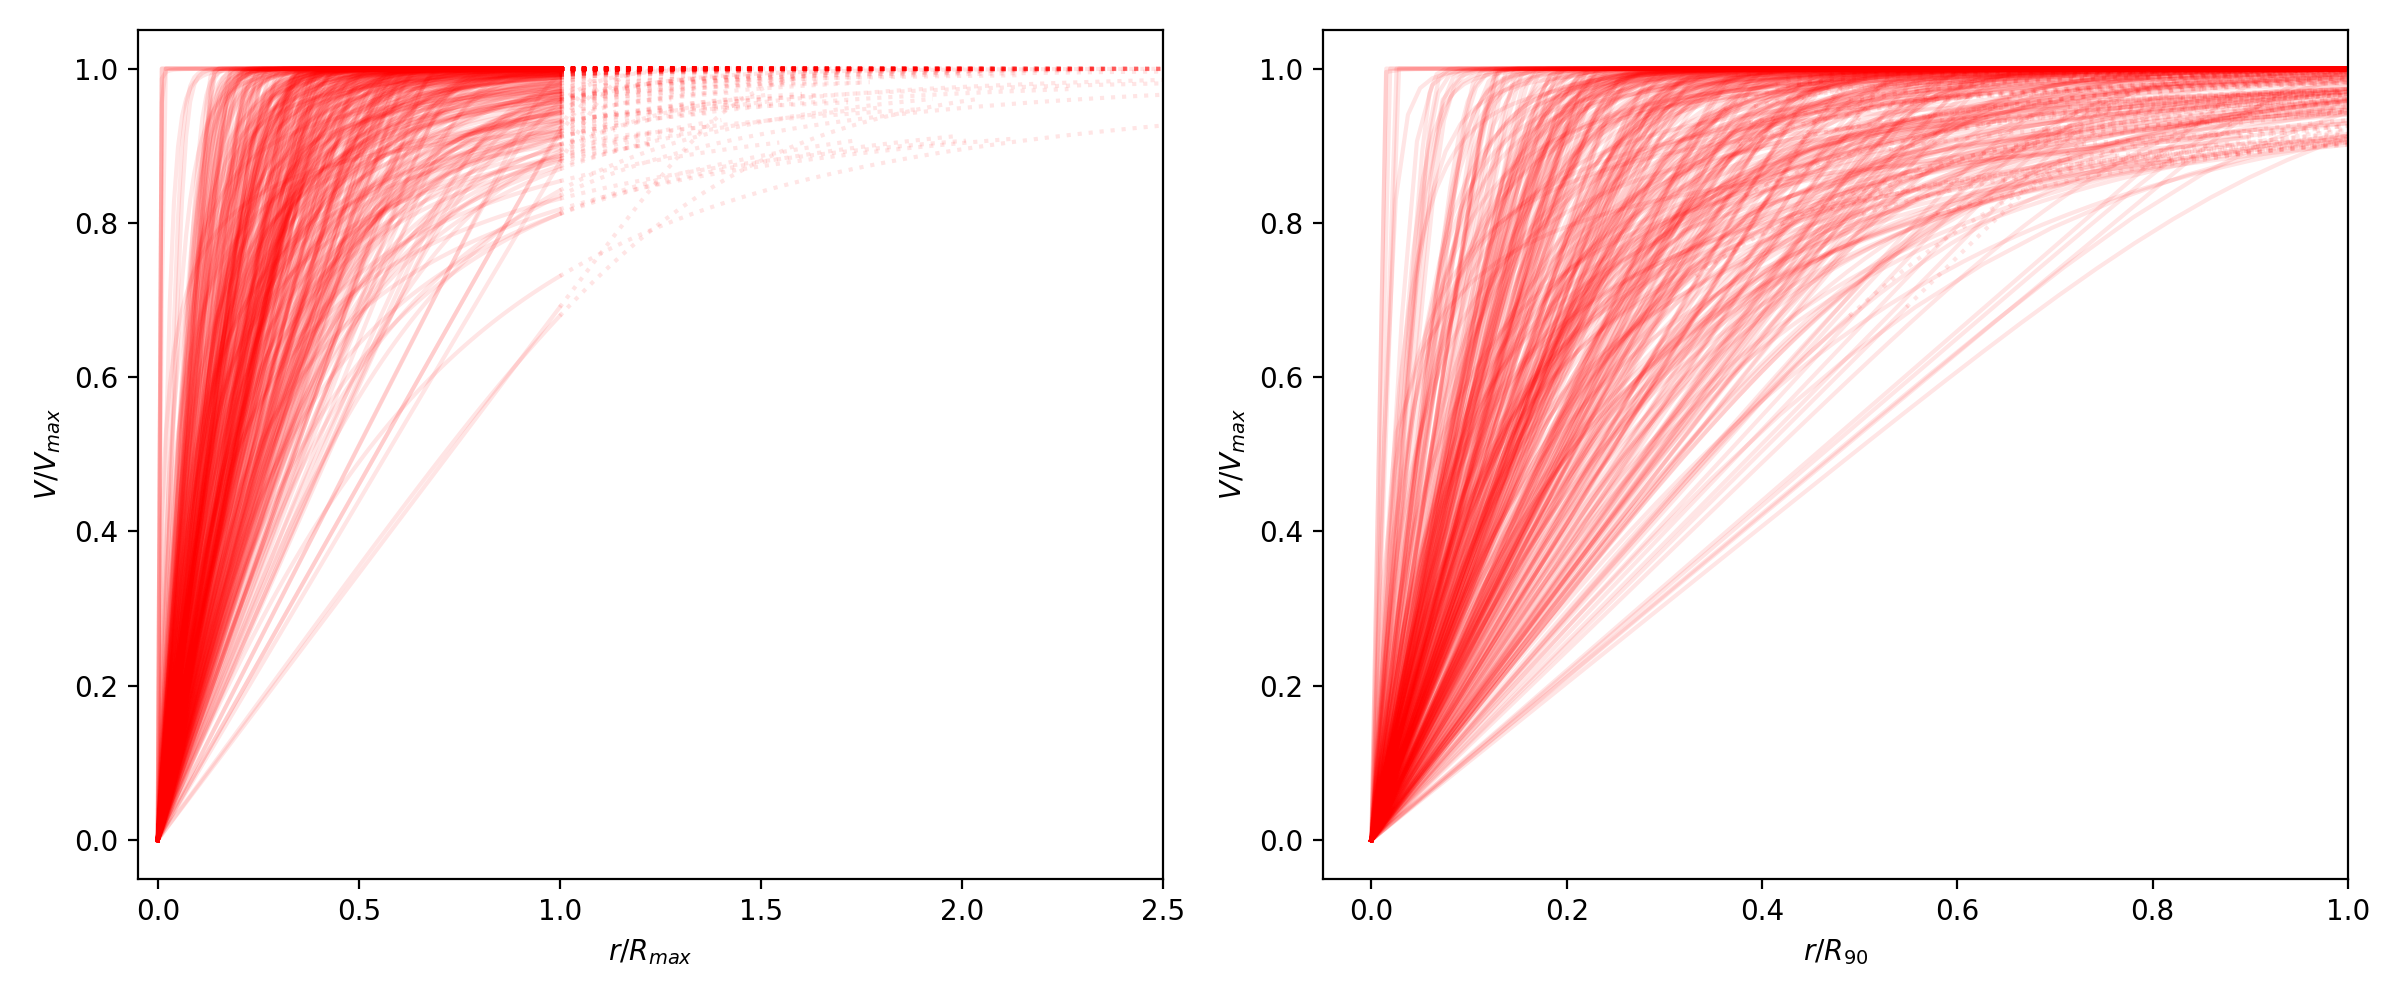

In [18]:
plt.figure(figsize=(12,5))


plt.subplot(121)

for i in range(len(RS)):
    alpha = RS['alpha_map'][i]
    Rturn = RS['Rturn_map'][i]
    Rmax = RS['Rmax_map'][i]
    R90 = RS['R90_kpc'][i]
    
    Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
    
    plt.plot(radii_max, Vr_max, 'r', alpha=0.1)
    
    if R90 > Rmax:
        radii_90 = np.linspace(1,R90/Rmax,50)
        Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
        plt.plot(radii_90, Vr_90, 'r:', alpha=0.1)

plt.xlim([-0.05, 2.5])

plt.xlabel('$r/R_{max}$')
plt.ylabel('$V/V_{max}$')



plt.subplot(122)

for i in range(len(RS)):
    alpha = RS['alpha_map'][i]
    Rturn = RS['Rturn_map'][i]
    Rmax = RS['Rmax_map'][i]
    R90 = RS['R90_kpc'][i]
    
    r_Rmax = np.linspace(0,Rmax/R90,50)
    
    Vr_max = r_Rmax*R90/(Rturn**alpha + (r_Rmax*R90)**alpha)**(1/alpha)
    
    plt.plot(r_Rmax, Vr_max, 'r', alpha=0.1)
    
    if R90 > Rmax:
        r_R90 = np.linspace(Rmax/R90,1,50)
        Vr_90 = r_R90*R90/(Rturn**alpha + (r_R90*R90)**alpha)**(1/alpha)
        plt.plot(r_R90, Vr_90, 'r:', alpha=0.1)


plt.xlim([-0.05, 1])

plt.xlabel('$r/R_{90}$')
plt.ylabel('$V/V_{max}$')

plt.tight_layout();

<IPython.core.display.Javascript object>


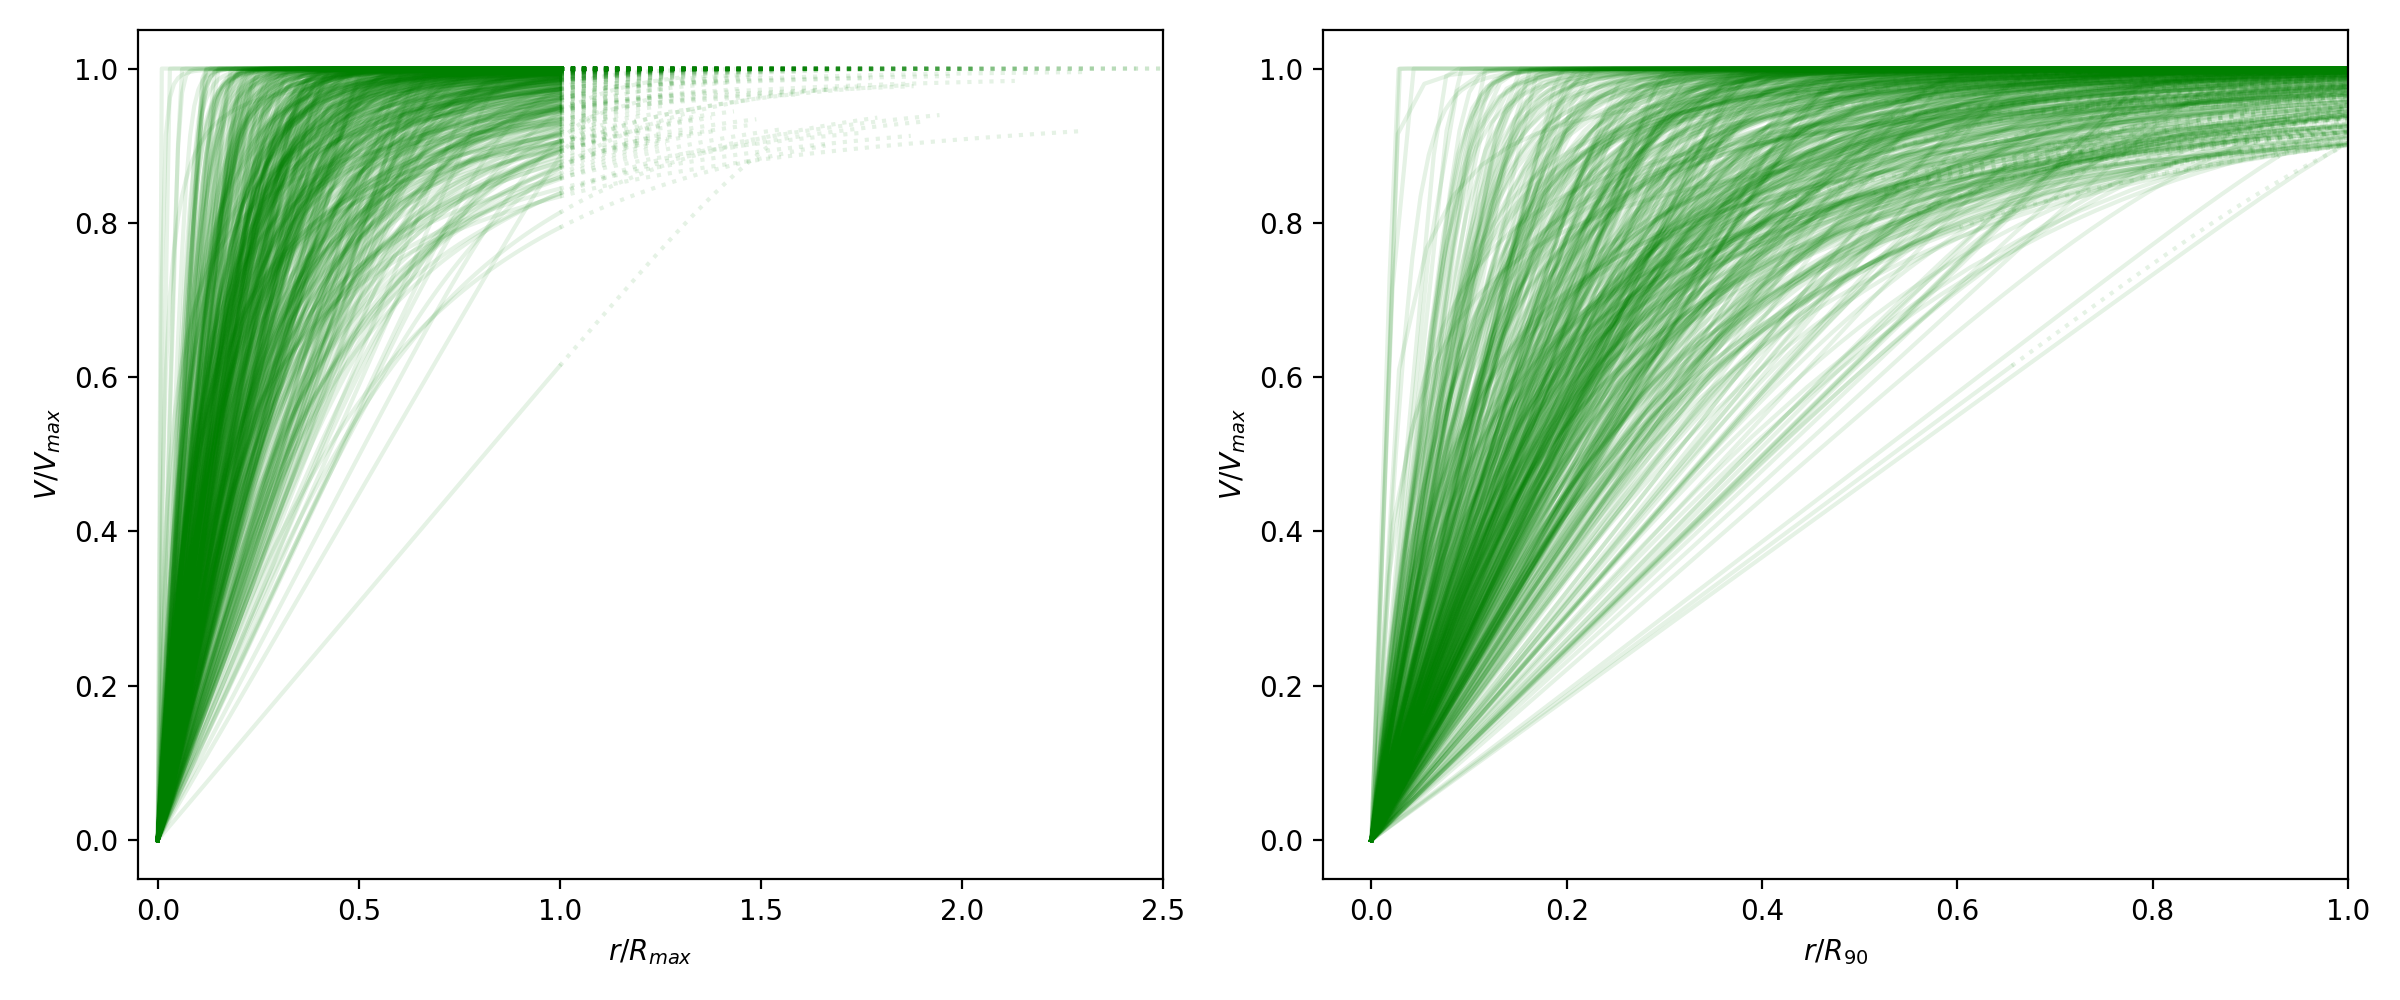

In [19]:
plt.figure(figsize=(12,5))


plt.subplot(121)

for i in range(len(GV)):
    alpha = GV['alpha_map'][i]
    Rturn = GV['Rturn_map'][i]
    Rmax = GV['Rmax_map'][i]
    R90 = GV['R90_kpc'][i]
    
    Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
    
    plt.plot(radii_max, Vr_max, 'g', alpha=0.1)
    
    if R90 > Rmax:
        radii_90 = np.linspace(1,R90/Rmax,50)
        Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
        plt.plot(radii_90, Vr_90, 'g:', alpha=0.1)

plt.xlim([-0.05, 2.5])

plt.xlabel('$r/R_{max}$')
plt.ylabel('$V/V_{max}$')



plt.subplot(122)

for i in range(len(GV)):
    alpha = GV['alpha_map'][i]
    Rturn = GV['Rturn_map'][i]
    Rmax = GV['Rmax_map'][i]
    R90 = GV['R90_kpc'][i]
    
    r_Rmax = np.linspace(0,Rmax/R90,50)
    
    Vr_max = r_Rmax*R90/(Rturn**alpha + (r_Rmax*R90)**alpha)**(1/alpha)
    
    plt.plot(r_Rmax, Vr_max, 'g', alpha=0.1)
    
    if R90 > Rmax:
        r_R90 = np.linspace(Rmax/R90,1,50)
        Vr_90 = r_R90*R90/(Rturn**alpha + (r_R90*R90)**alpha)**(1/alpha)
        plt.plot(r_R90, Vr_90, 'g:', alpha=0.1)


plt.xlim([-0.05, 1])

plt.xlabel('$r/R_{90}$')
plt.ylabel('$V/V_{max}$')

plt.tight_layout();

<IPython.core.display.Javascript object>


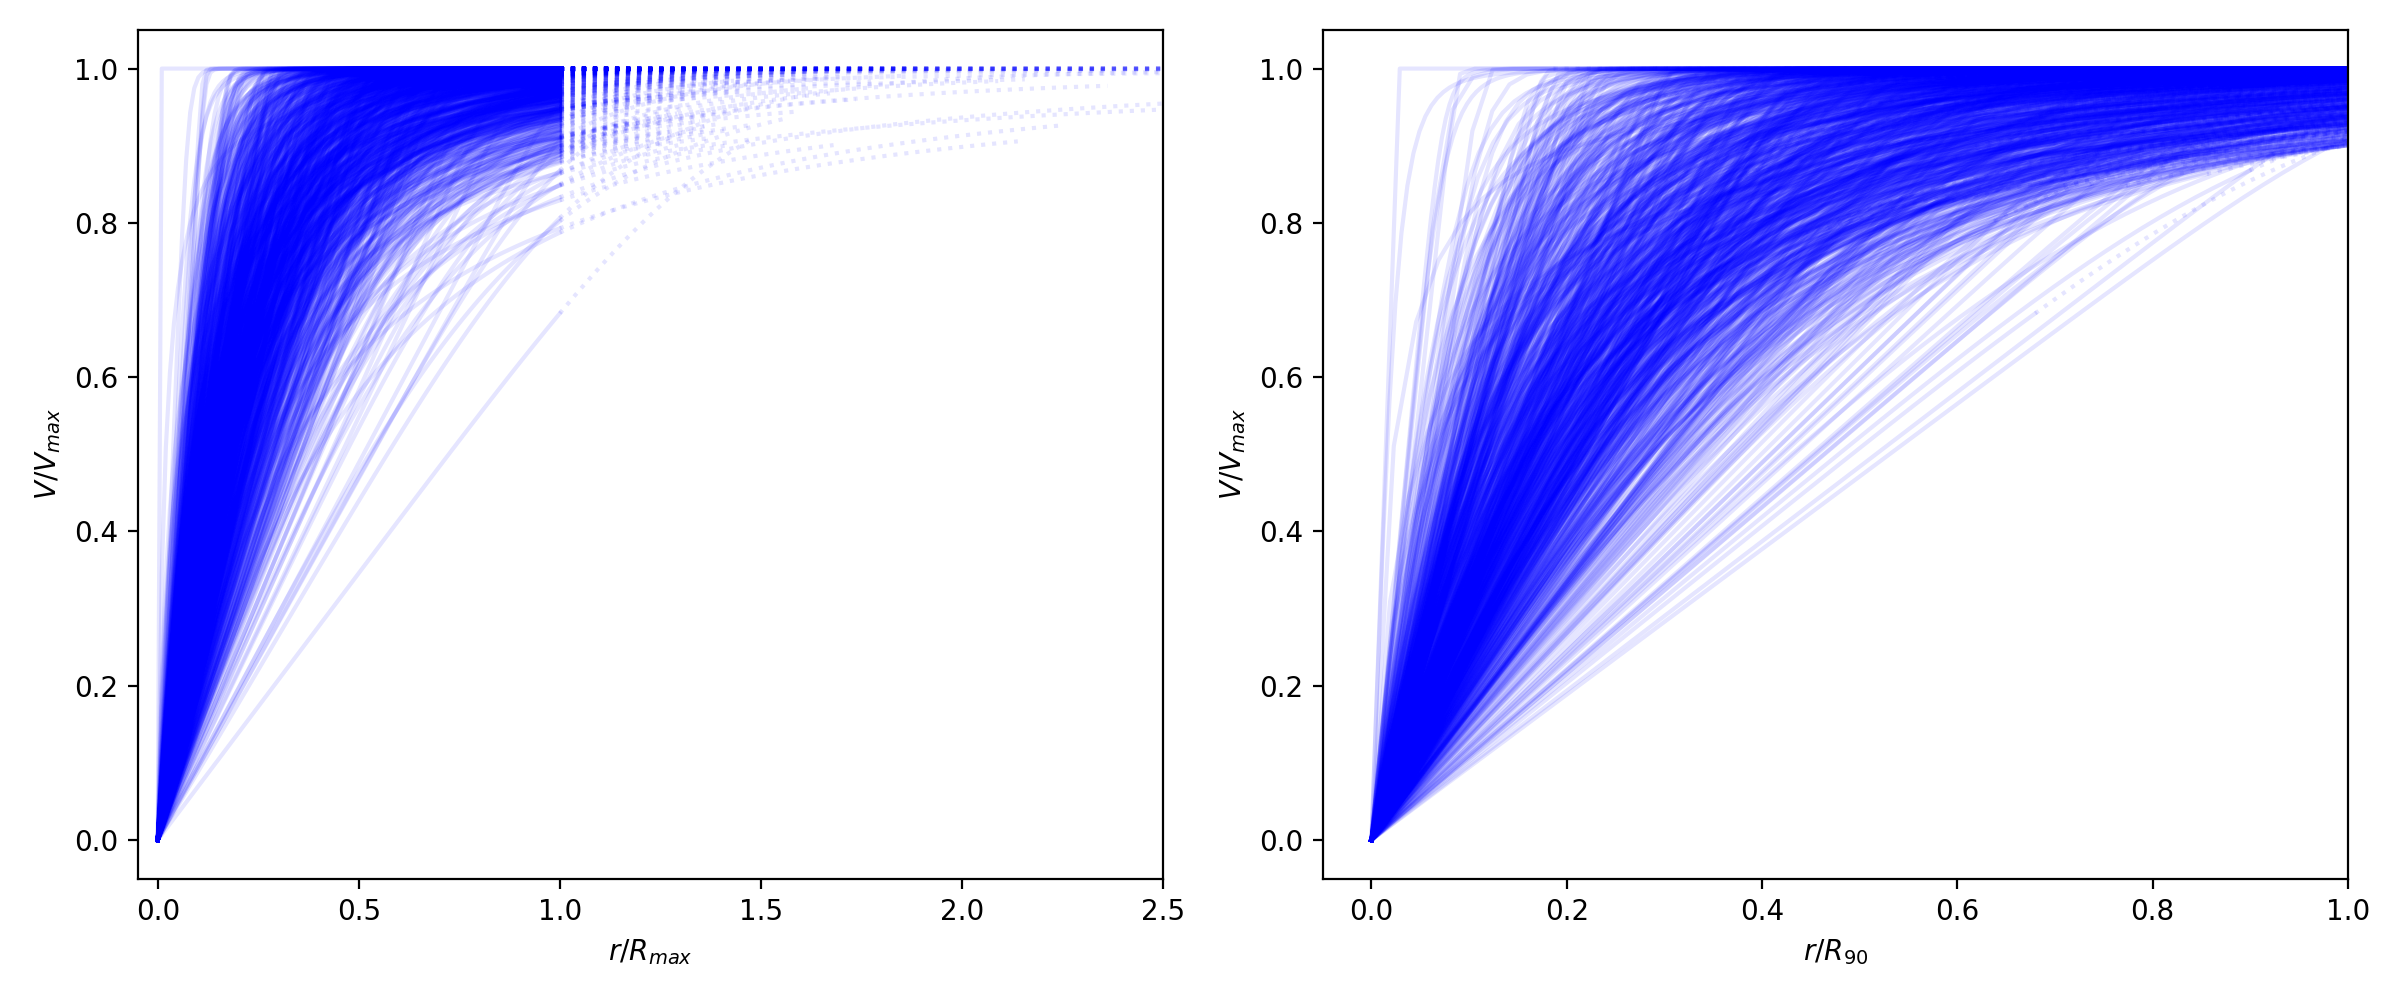

In [20]:
plt.figure(figsize=(12,5))


plt.subplot(121)

for i in range(len(BC)):
    alpha = BC['alpha_map'][i]
    Rturn = BC['Rturn_map'][i]
    Rmax = BC['Rmax_map'][i]
    R90 = BC['R90_kpc'][i]
    
    Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
    
    plt.plot(radii_max, Vr_max, 'b', alpha=0.1)
    
    if R90 > Rmax:
        radii_90 = np.linspace(1,R90/Rmax,50)
        Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
        plt.plot(radii_90, Vr_90, 'b:', alpha=0.1)

plt.xlim([-0.05, 2.5])

plt.xlabel('$r/R_{max}$')
plt.ylabel('$V/V_{max}$')



plt.subplot(122)

for i in range(len(BC)):
    alpha = BC['alpha_map'][i]
    Rturn = BC['Rturn_map'][i]
    Rmax = BC['Rmax_map'][i]
    R90 = BC['R90_kpc'][i]
    
    r_Rmax = np.linspace(0,Rmax/R90,50)
    
    Vr_max = r_Rmax*R90/(Rturn**alpha + (r_Rmax*R90)**alpha)**(1/alpha)
    
    plt.plot(r_Rmax, Vr_max, 'b', alpha=0.1)
    
    if R90 > Rmax:
        r_R90 = np.linspace(Rmax/R90,1,50)
        Vr_90 = r_R90*R90/(Rturn**alpha + (r_R90*R90)**alpha)**(1/alpha)
        plt.plot(r_R90, Vr_90, 'b:', alpha=0.1)


plt.xlim([-0.05, 1])

plt.xlabel('$r/R_{90}$')
plt.ylabel('$V/V_{max}$')

plt.tight_layout();

# Distribution in velocity

In [21]:
def hist_norm(x, bins):
    '''
    Calculate the normalized histogram, where the height of each bin 
    is normalized by the total number of objects in the sample.
    
    
    PARAMETERS
    ==========
    
    x : ndarrary of shape (n,)
        Array of data to be histogrammed
        
    bins : ndarray of shape (m,)
        Bin edges
        
        
    RETURNS
    =======
    
    norm_binned_x : ndarray of shape (m,)
        Number of objects in each bin, normalized by the total number of objects in the sample
    '''
    
    # Histogram the data
    binned_x, _ = np.histogram(x, bins=bins)
    
    # Normalize binned data by the number of objects
    norm_binned_x = binned_x/len(x)
    
    # Append a 0 onto the end of the array (to draw the last line back down)
    return np.append(norm_binned_x, [0])

<IPython.core.display.Javascript object>


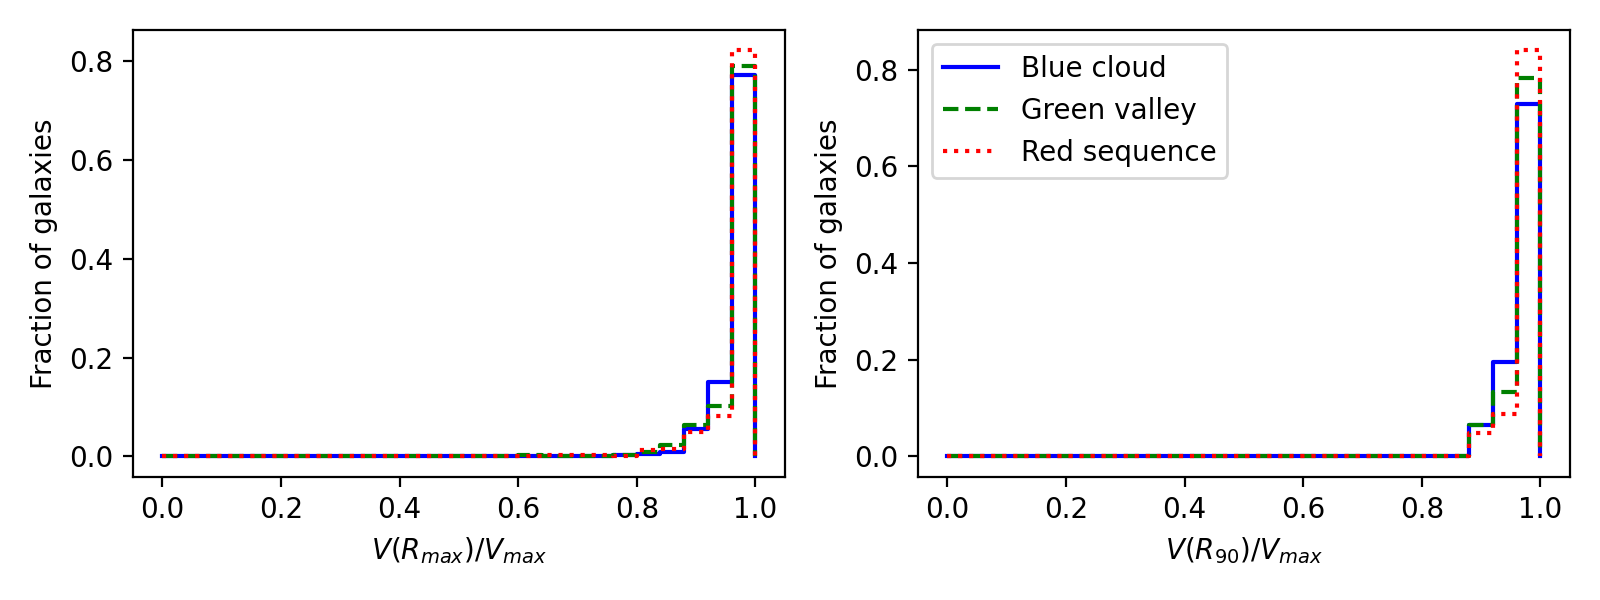

In [22]:
V_bins = np.arange(0,1.04,0.04)

plt.figure(figsize=(8,3))



plt.subplot(121)

plt.step(V_bins, 
         hist_norm(BC['VRmax_kms']/BC['Vmax_map'], V_bins),
         'b', 
         where='post', 
         label='Blue cloud')
plt.step(V_bins, 
         hist_norm(GV['VRmax_kms']/GV['Vmax_map'], V_bins), 
         'g--', 
         where='post', 
         label='Green valley')
plt.step(V_bins, 
         hist_norm(RS['VRmax_kms']/RS['Vmax_map'], V_bins), 
         'r:', 
         where='post', 
         label='Red sequence')

plt.xlabel('$V(R_{max})/V_{max}$')
plt.ylabel('Fraction of galaxies')



plt.subplot(122)

plt.step(V_bins, 
         hist_norm(BC['V90_kms']/BC['Vmax_map'], V_bins), 
         'b', 
         where='post', 
         label='Blue cloud')
plt.step(V_bins, 
         hist_norm(GV['V90_kms']/GV['Vmax_map'], V_bins), 
         'g--', 
         where='post', 
         label='Green valley')
plt.step(V_bins, 
         hist_norm(RS['V90_kms']/RS['Vmax_map'], V_bins), 
         'r:', 
         where='post', 
         label='Red sequence')

plt.xlabel('$V(R_{90})/V_{max}$')
plt.ylabel('Fraction of galaxies')

plt.legend(loc='upper left')

plt.tight_layout();

# Relationship between $M_*$ and $M_\text{tot}$

In [23]:
def bin_median(data, bin_quantity, bins, median_quantity):
    '''
    Calculate the median value of the quantity median_quantity when the objects in 
    data are binned by bin_quanitity.
    
    
    PARAMETERS
    ==========
    
    data : astropy table
        Galaxy data
        
    bin_quantity : string
        Name of column in data by which to bin the data
        
    bins : ndarray of shape (n,)
        Array of bin edges
        
    median_quantity : string
        Name of column in data for which to calculate the median once the data is 
        binned
        
        
    RETURNS
    =======
    
    binned_data : ndarray of shape (n,)
        Median values of median_quantity for each bin of bin_quantity
        
    binned_err : ndarray of shape (n,)
        Statistical uncertainty in each bin (1/sqrt(N), where N is the number of 
        objects in the bin)
    '''
    
    if bin_quantity in ['Mstar', 'NSA_Mstar', 'Mstar_NSA']:
        bin_indices = np.digitize(np.log10(data[bin_quantity]), bins)
    else:
        bin_indices = np.digitize(data[bin_quantity], bins)
    
    n_bins = len(bins)
    
    binned_median = np.zeros(n_bins)
    binned_err = np.zeros(n_bins)
    
    for i in range(n_bins):
        # Find galaxies in this bin
        gal_in_bin = bin_indices == i
        
        # Calculate median of galaxies in bin
        if median_quantity in ['Mstar', 'NSA_Mstar', 'Mtot', 'Mstar_NSA']:
            binned_median[i] = np.log10(np.nanmedian(data[median_quantity][gal_in_bin]))
        elif median_quantity in ['M90_map', 'logHI']:
            binned_median[i] = np.log10(np.nanmedian(10**data[median_quantity][gal_in_bin]))
        else:
            binned_median[i] = np.nanmedian(data[median_quantity][gal_in_bin])
        
        # Calculate statistical uncertainty in bin
        binned_err[i] = 1/np.sqrt(sum(gal_in_bin))
        
    return binned_median, binned_err

In [24]:
Mdisk_bins = np.linspace(9,11.5,9)
Mdisk_bin_width = Mdisk_bins[1] - Mdisk_bins[0]

BC_M90_medians, BC_M90_errs = bin_median(BC, 'M90_disk_map', Mdisk_bins, 'M90_map')
GV_M90_medians, GV_M90_errs = bin_median(GV, 'M90_disk_map', Mdisk_bins, 'M90_map')
RS_M90_medians, RS_M90_errs = bin_median(RS, 'M90_disk_map', Mdisk_bins, 'M90_map')

<IPython.core.display.Javascript object>


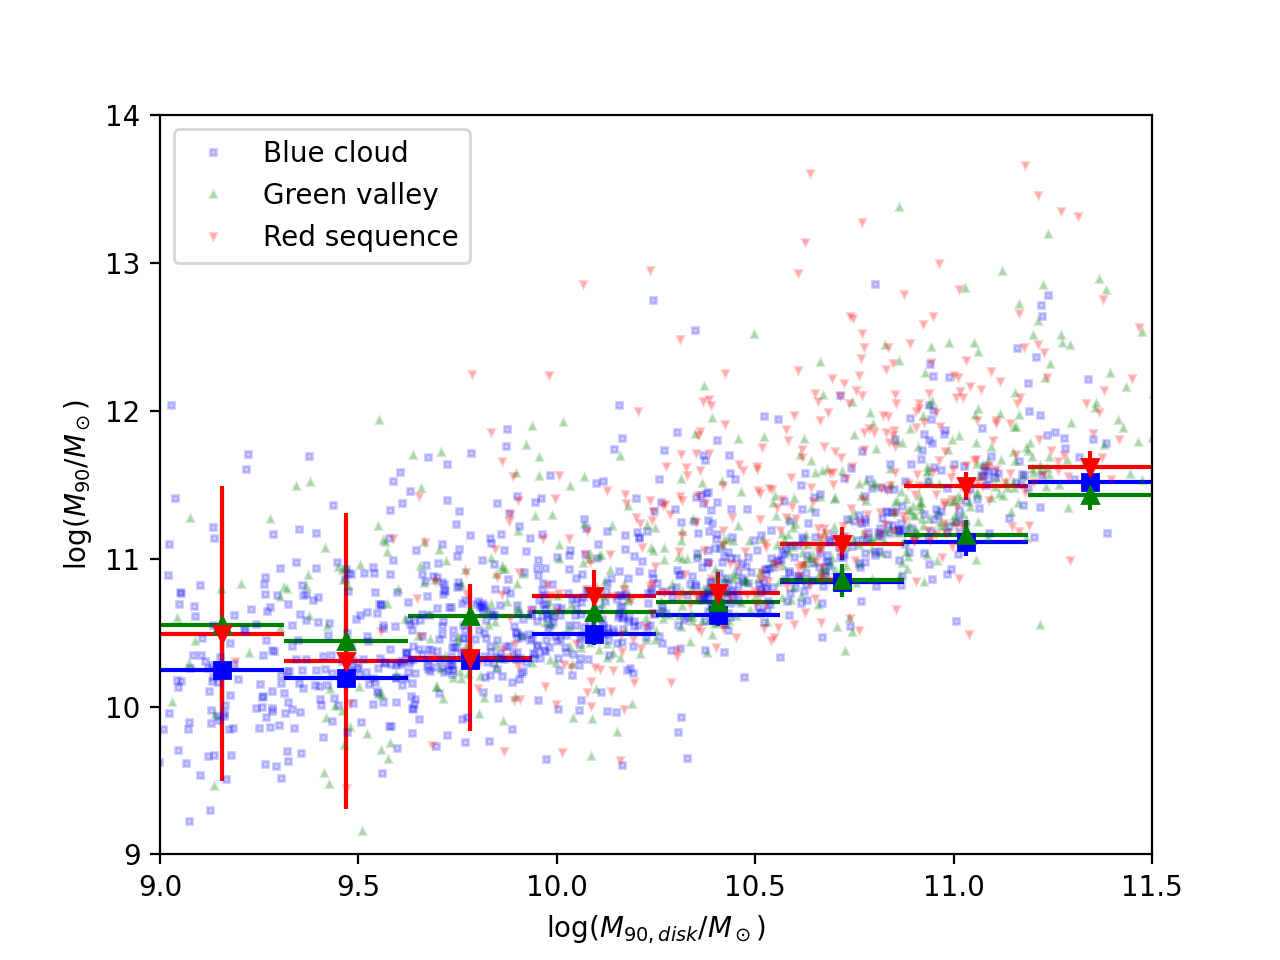

In [25]:
plt.figure()

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.plot(BC['M90_disk_map'], BC['M90_map'], 'bs', markersize=2, alpha=0.2, label='Blue cloud')
plt.plot(GV['M90_disk_map'], GV['M90_map'], 'g^', markersize=2, alpha=0.2, label='Green valley')
plt.plot(RS['M90_disk_map'], RS['M90_map'], 'rv', markersize=2, alpha=0.2, label='Red sequence')

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, BC_M90_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=BC_M90_errs, 
             c='b', fmt='s')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, GV_M90_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=GV_M90_errs, 
             c='g', fmt='^')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, RS_M90_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=RS_M90_errs, 
             c='r', fmt='v')

plt.xlabel('log($M_{90, disk}/M_\odot$)')
plt.ylabel('log($M_{90}/M_\odot$)')

plt.xlim([9,11.5])
plt.ylim([9,14])

plt.legend();
################################################################################

# Relationship between $M_*$ and $M_{HI}$

In [50]:
BC_HI_medians, BC_HI_errs = bin_median(BC_HI, 'M90_disk_map', Mdisk_bins, 'logHI')
GV_HI_medians, GV_HI_errs = bin_median(GV_HI, 'M90_disk_map', Mdisk_bins, 'logHI')
RS_HI_medians, RS_HI_errs = bin_median(RS_HI, 'M90_disk_map', Mdisk_bins, 'logHI')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_7901/1303199474.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  binned_err[i] = 1/np.sqrt(sum(gal_in_bin))


<IPython.core.display.Javascript object>


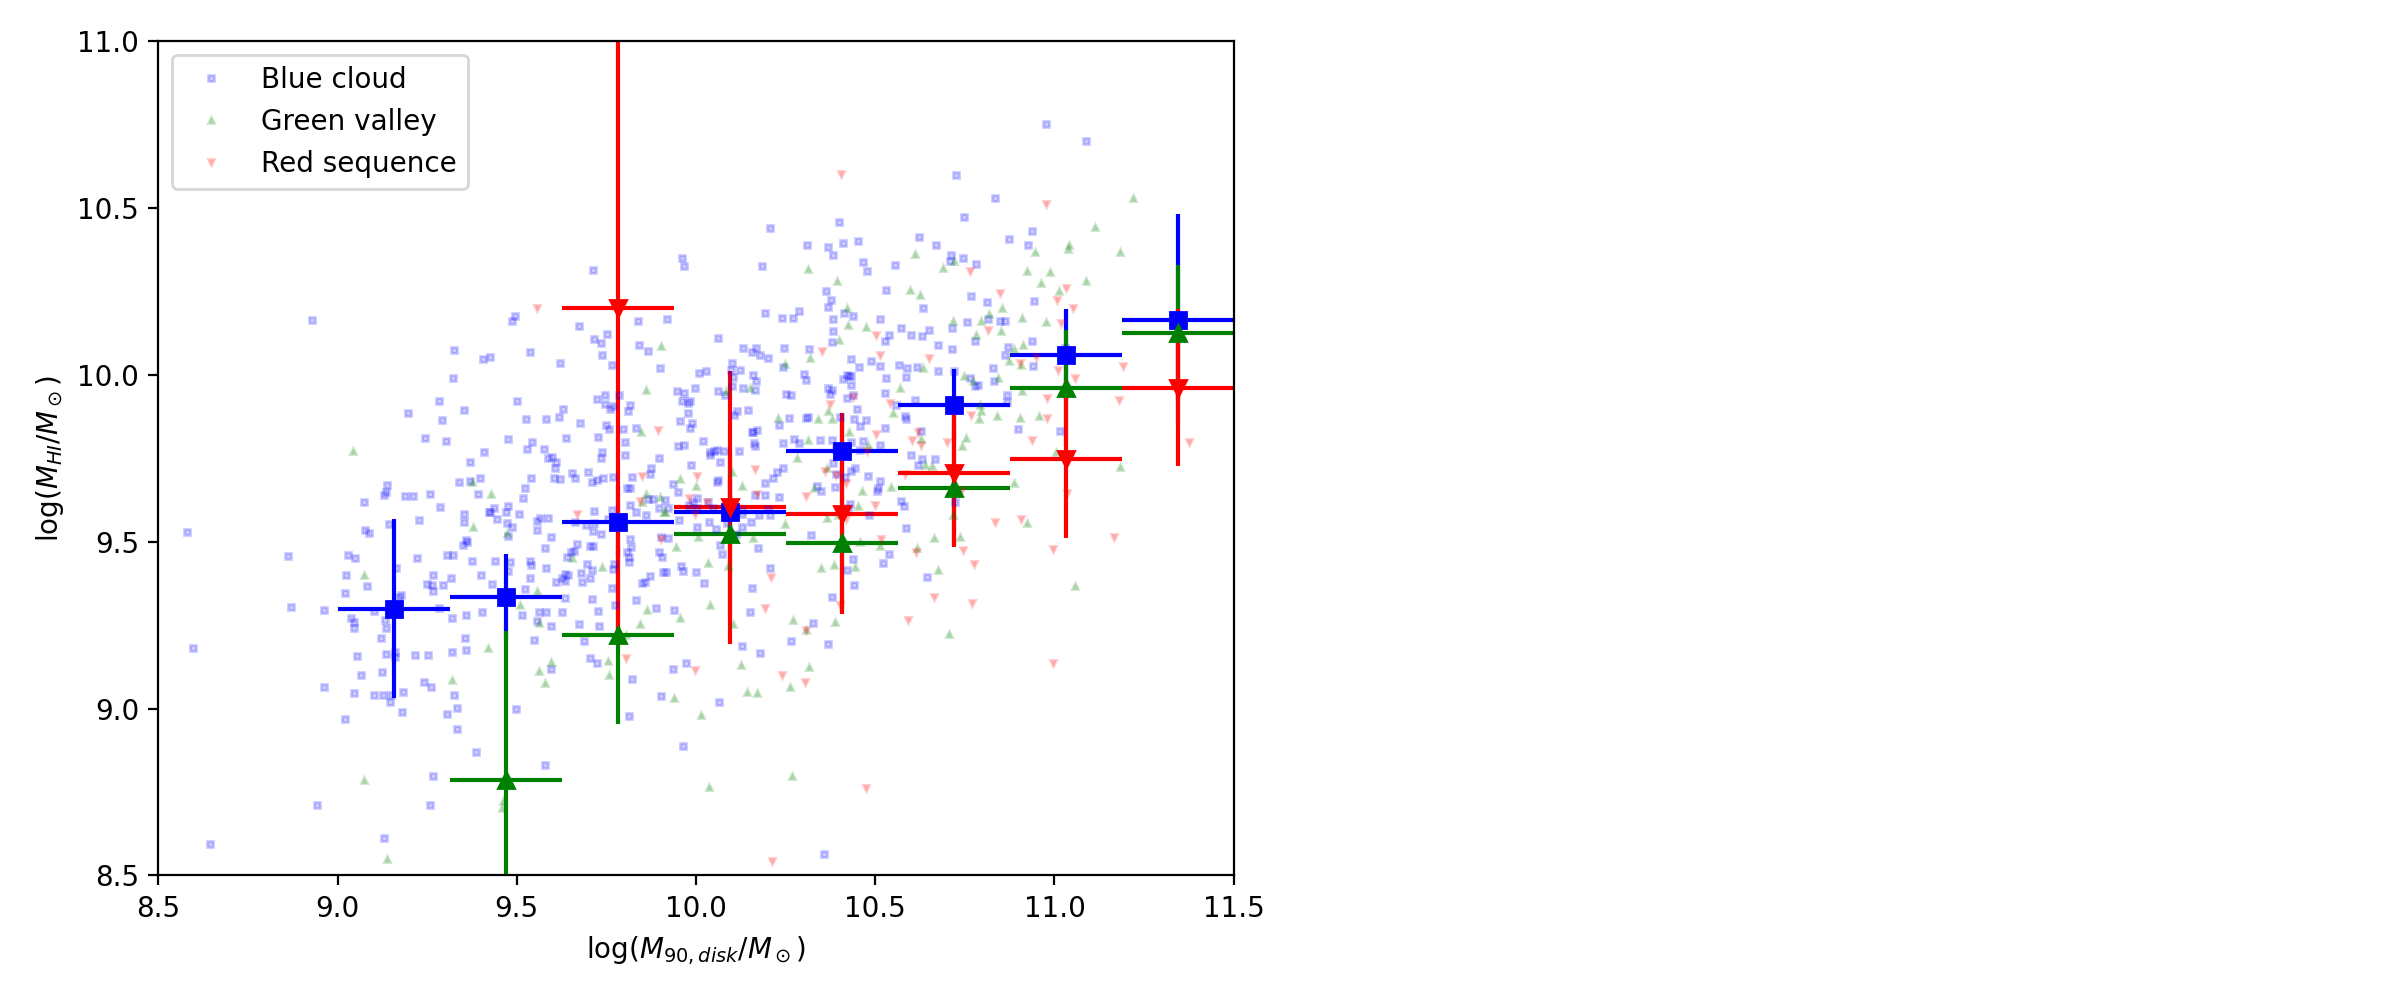

In [28]:
plt.figure(figsize=(12,5))

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.subplot(121)
plt.plot(BC_HI['M90_disk_map'], BC_HI['logHI'], 'bs', markersize=2, 
         alpha=0.2, label='Blue cloud')
plt.plot(GV_HI['M90_disk_map'], GV_HI['logHI'], 'g^', markersize=2, 
         alpha=0.2, label='Green valley')
plt.plot(RS_HI['M90_disk_map'], RS_HI['logHI'], 'rv', markersize=2, 
         alpha=0.2, label='Red sequence')

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, BC_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=BC_HI_errs, 
             c='b', fmt='s')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, GV_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=GV_HI_errs, 
             c='g', fmt='^')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, RS_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=RS_HI_errs, 
             c='r', fmt='v')

plt.xlabel('log($M_{90, disk}/M_\odot$)')
plt.ylabel('log($M_{HI}/M_\odot$)')

plt.xlim([8.5,11.5])
plt.ylim([8.5,11])

plt.legend()
################################################################################

'''
################################################################################
# SDSS DR7
#-------------------------------------------------------------------------------
plt.subplot(122)

plt.plot(np.log10(kias_BC['Mstar_NSA']), kias_BC['HImass'], 's', 
         color='CornflowerBlue', markersize=2, alpha=0.2)
plt.plot(np.log10(kias_GV['Mstar_NSA']), kias_GV['HImass'], 'g^', markersize=2, 
         alpha=0.2)
plt.plot(np.log10(kias_RS['Mstar_NSA']), kias_RS['HImass'], 'rv', markersize=2, 
         alpha=0.2)
         
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, kias_BC_NSA_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=kias_BC_NSA_HI_errs, 
             c='b', fmt='s', label='Blue cloud')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, kias_GV_NSA_HI_medians, 
             
             xerr=0.5*Mdisk_bin_width, yerr=kias_GV_NSA_HI_errs, 
             c='g', fmt='^', label='Green valley')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, kias_RS_NSA_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=kias_RS_NSA_HI_errs, 
             c='r', fmt='v', label='Red sequence')

plt.xlabel('log($M_*/M_\odot$) (NSA)')
plt.ylabel('log($M_{HI}/M_\odot$)')

plt.xlim([8,11.5])
plt.ylim([8,11])

plt.legend()
################################################################################
''';
plt.tight_layout();

# Relationship between $M_{vis}$ and $M_{90}$

In [29]:
BC_Mvis_medians, BC_Mvis_errs = bin_median(BC_HI, 'M90_vis', Mdisk_bins, 'M90_map')
GV_Mvis_medians, GV_Mvis_errs = bin_median(GV_HI, 'M90_vis', Mdisk_bins, 'M90_map')
RS_Mvis_medians, RS_Mvis_errs = bin_median(RS_HI, 'M90_vis', Mdisk_bins, 'M90_map')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_7901/1303199474.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  binned_err[i] = 1/np.sqrt(sum(gal_in_bin))


<IPython.core.display.Javascript object>


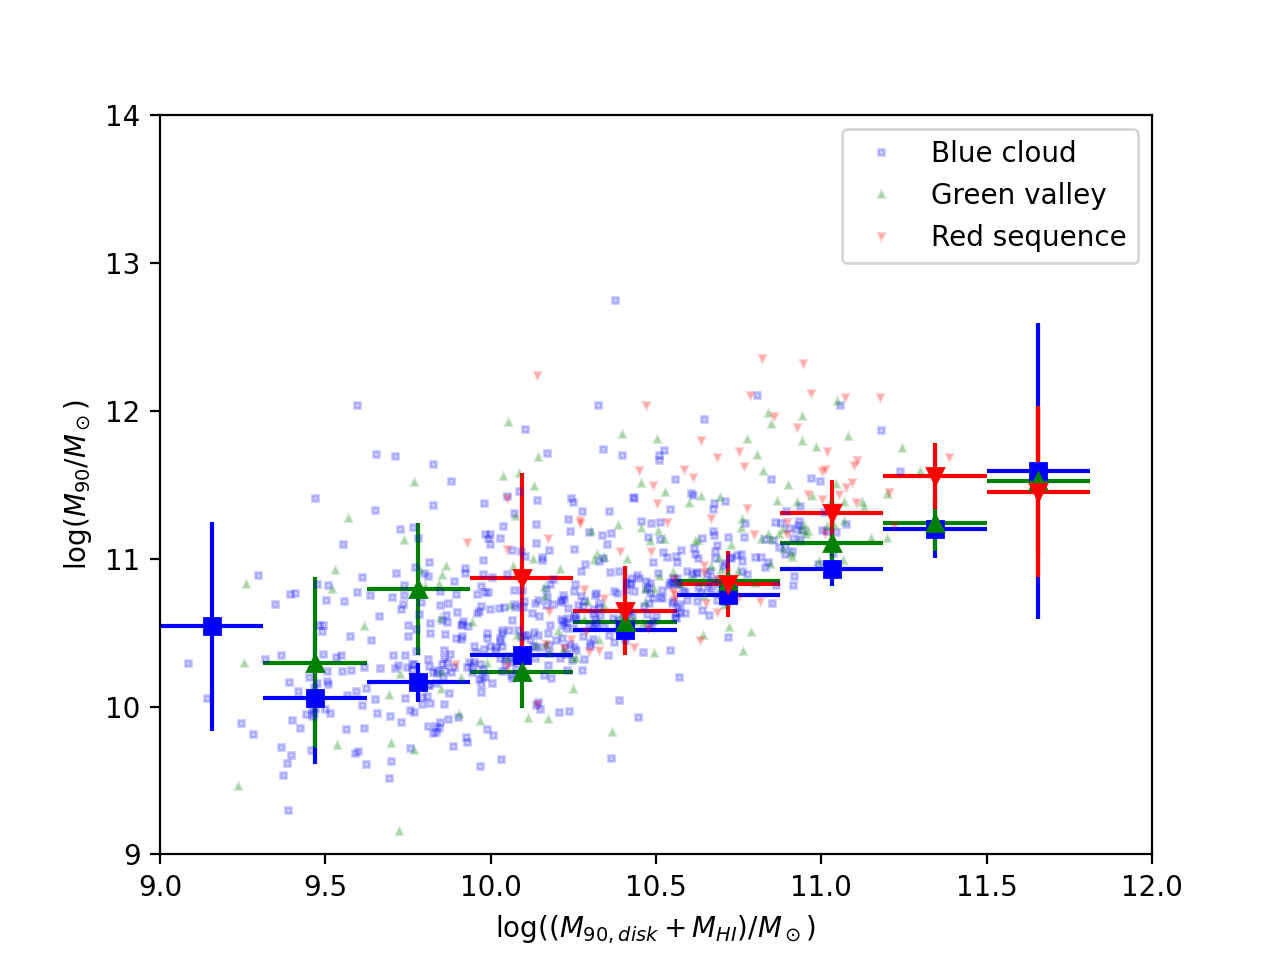

In [30]:
plt.figure()

plt.plot(BC_HI['M90_vis'], BC_HI['M90_map'], 
         'bs', markersize=2, alpha=0.2, label='Blue cloud')
plt.plot(GV_HI['M90_vis'], GV_HI['M90_map'], 
         'g^', markersize=2, alpha=0.2, label='Green valley')
plt.plot(RS_HI['M90_vis'], RS_HI['M90_map'], 
         'rv', markersize=2, alpha=0.2, label='Red sequence')

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, BC_Mvis_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=BC_Mvis_errs, 
             c='b', fmt='s')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, GV_Mvis_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=GV_Mvis_errs, 
             c='g', fmt='^')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, RS_Mvis_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=RS_Mvis_errs, 
             c='r', fmt='v')

plt.xlabel('log(($M_{90, disk} + M_{HI})/M_\odot$)')
plt.ylabel('log($M_{90}/M_\odot$)')

plt.xlim([9,12])
plt.ylim([9,14])

plt.legend();

# Distribution in mass ratios

In [31]:
def hist_norm(data, bins):
    '''
    Return the values to plot a normalized histogram.
    
    
    PARAMETERS
    ==========
    
    data : column of astropy table
        Data to be binned
        
    bins : ndarray of shape (n,)
        Bin edges
        
        
    RETURNS
    =======
    
    binned_data : ndarray of shape (n,)
        Number of objects in each bin, normalized by the total number of 
        objects in the sample
        
    binned_data_err : ndarray of shape (n,)
        Statistical uncertainty in the count in each bin.
    '''
    
    # Bin data
    counts,_ = np.histogram(data, bins=bins)
    
    # Normalize binned data
    binned_data = counts/len(data)
    
    # Calculate uncertainty in each bin
    binned_data_err = np.sqrt(counts)/len(data)
    
    return binned_data, binned_data_err

In [32]:
mass_bins = np.linspace(0,25,101)
mass_bin_width = mass_bins[1] - mass_bins[0]

BC_M90Mdisk_binned, BC_M90Mdisk_err = hist_norm(BC['M90_Mdisk_ratio'], bins=mass_bins)
GV_M90Mdisk_binned, GV_M90Mdisk_err = hist_norm(GV['M90_Mdisk_ratio'], bins=mass_bins)
RS_M90Mdisk_binned, RS_M90Mdisk_err = hist_norm(RS['M90_Mdisk_ratio'], bins=mass_bins)

### $M_{90}/M_{90, \text{disk}}$

<IPython.core.display.Javascript object>


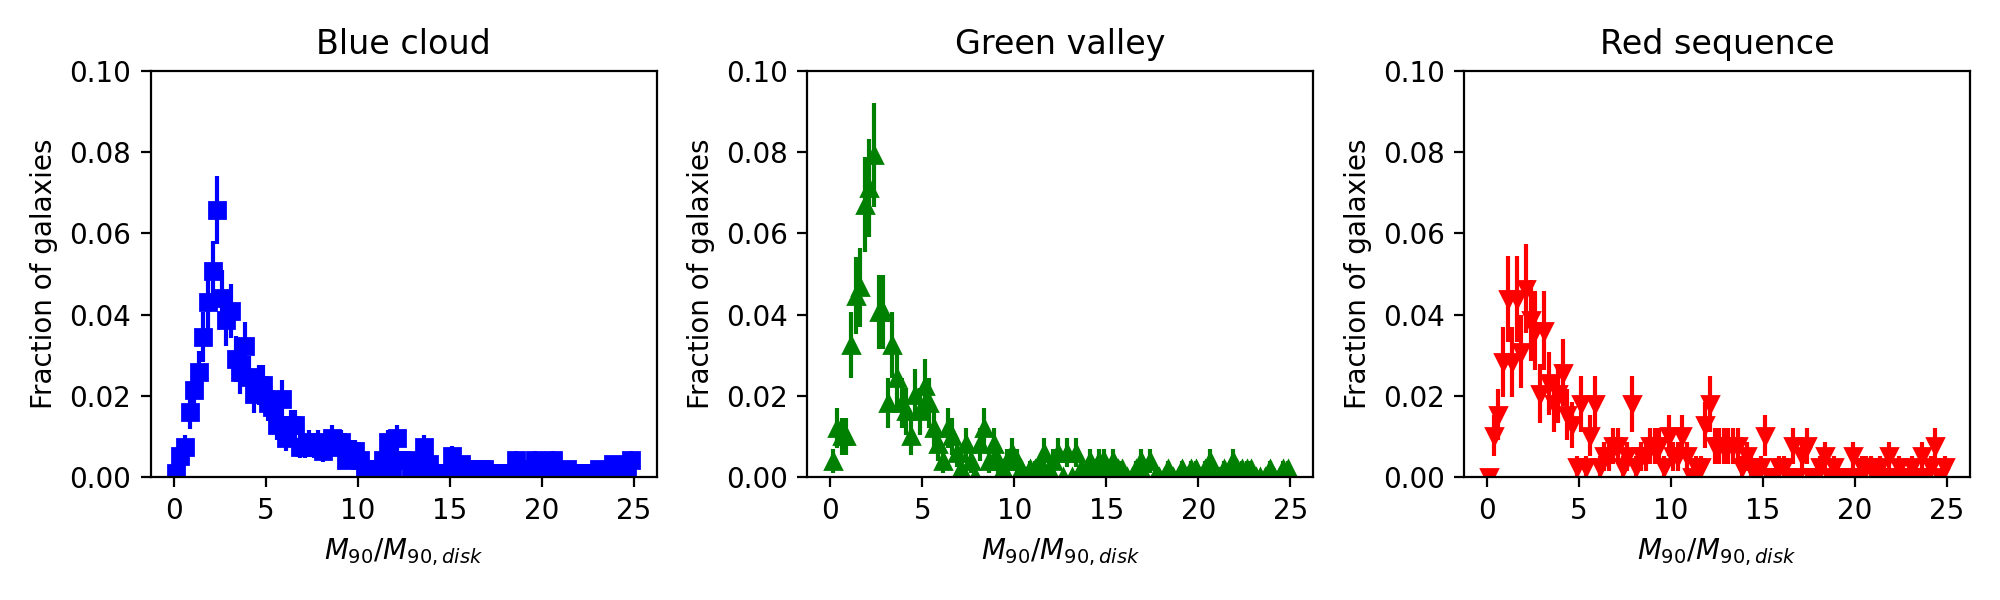

In [33]:
plt.figure(figsize=(10,3))

y_max = 0.1

################################################################################
# Blue cloud
#-------------------------------------------------------------------------------
plt.subplot(131)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, BC_M90Mdisk_binned, 
             xerr=0.5*mass_bin_width, yerr=BC_M90Mdisk_err, fmt='bs')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/M_{90, disk}$')
plt.ylabel('Fraction of galaxies')

plt.title('Blue cloud')
################################################################################


################################################################################
# Green valley
#-------------------------------------------------------------------------------
plt.subplot(132)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, GV_M90Mdisk_binned, 
             xerr=0.5*mass_bin_width, yerr=GV_M90Mdisk_err, fmt='g^')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/M_{90, disk}$')
plt.ylabel('Fraction of galaxies')

plt.title('Green valley')
################################################################################


################################################################################
# Red sequence
#-------------------------------------------------------------------------------
plt.subplot(133)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, RS_M90Mdisk_binned, 
             xerr=0.5*mass_bin_width, yerr=RS_M90Mdisk_err, fmt='rv')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/M_{90, disk}$')
plt.ylabel('Fraction of galaxies')

plt.title('Red sequence')
################################################################################

plt.tight_layout();

### $M_{90}/(M_{90, \text{disk}} + M_\text{HI})$

In [34]:
BC_M90Mvis_binned, BC_M90Mvis_err = hist_norm(BC_HI['M90_MdiskHI_ratio'], bins=mass_bins)
GV_M90Mvis_binned, GV_M90Mvis_err = hist_norm(GV_HI['M90_MdiskHI_ratio'], bins=mass_bins)
RS_M90Mvis_binned, RS_M90Mvis_err = hist_norm(RS_HI['M90_MdiskHI_ratio'], bins=mass_bins)

<IPython.core.display.Javascript object>


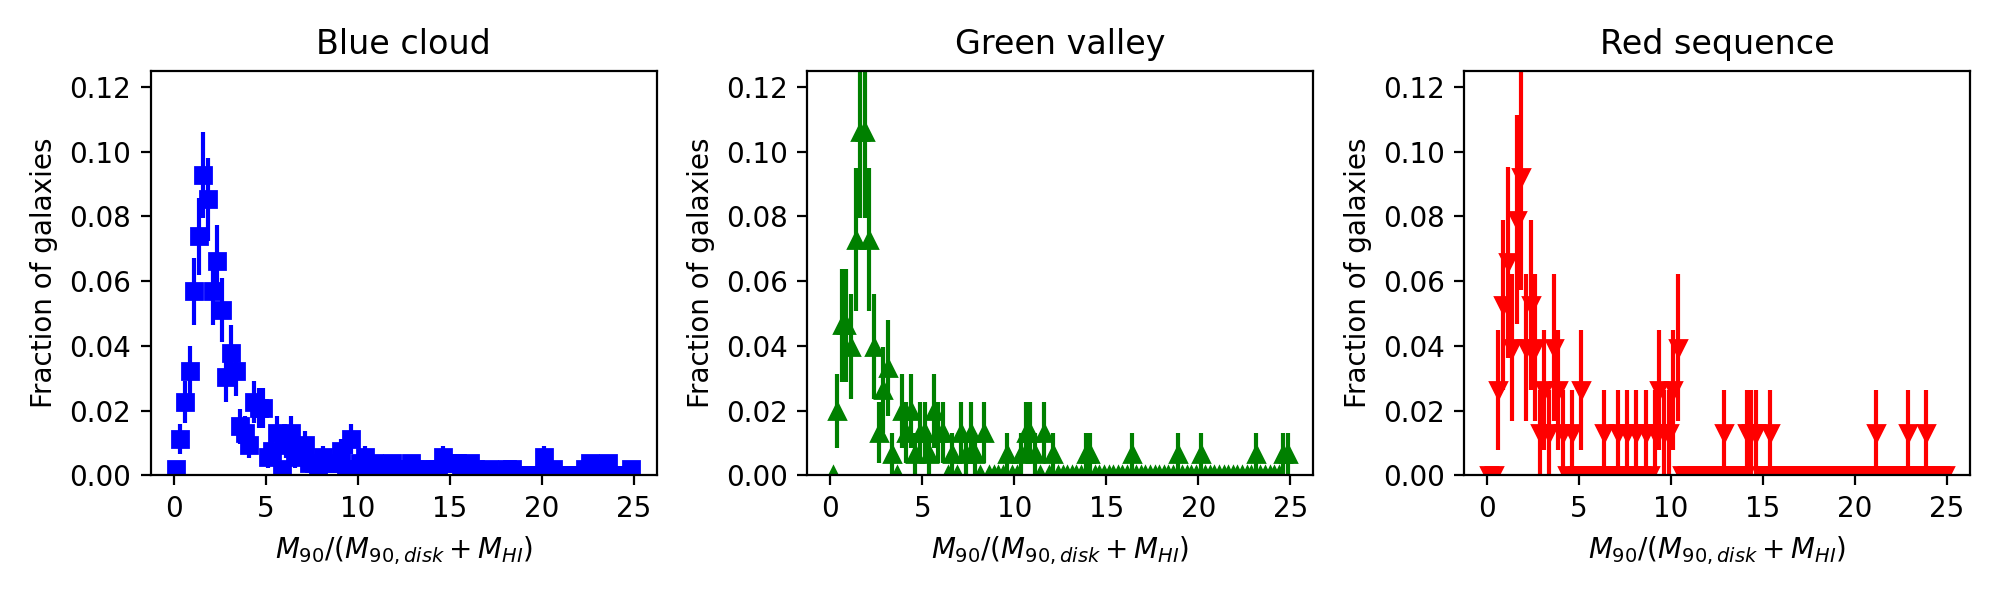

In [35]:
plt.figure(figsize=(10,3))

y_max = 0.125

################################################################################
# Blue cloud
#-------------------------------------------------------------------------------
plt.subplot(131)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, BC_M90Mvis_binned, 
             xerr=0.5*mass_bin_width, yerr=BC_M90Mvis_err, fmt='bs')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/(M_{90, disk} + M_{HI})$')
plt.ylabel('Fraction of galaxies')

plt.title('Blue cloud')
################################################################################


################################################################################
# Green valley
#-------------------------------------------------------------------------------
plt.subplot(132)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, GV_M90Mvis_binned, 
             xerr=0.5*mass_bin_width, yerr=GV_M90Mvis_err, fmt='g^')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/(M_{90, disk} + M_{HI})$')
plt.ylabel('Fraction of galaxies')

plt.title('Green valley')
################################################################################


################################################################################
# Red sequence
#-------------------------------------------------------------------------------
plt.subplot(133)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, RS_M90Mvis_binned, 
             xerr=0.5*mass_bin_width, yerr=RS_M90Mvis_err, fmt='rv')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/(M_{90, disk} + M_{HI})$')
plt.ylabel('Fraction of galaxies')

plt.title('Red sequence')
################################################################################

plt.tight_layout();

# Relationship between $M_r$ and the mass ratios

In [36]:
Mr_bins = np.linspace(-22.5, -17.5, 16)
Mr_bin_width = Mr_bins[1] - Mr_bins[0]

Mdisk_medians, Mdisk_errs = bin_median(good_galaxies, 'rabsmag', Mr_bins, 'M90_Mdisk_ratio')
MdiskHI_medians, MdiskHI_errs = bin_median(goodHI_galaxies, 'rabsmag', Mr_bins, 'M90_MdiskHI_ratio')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_7901/1303199474.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  binned_err[i] = 1/np.sqrt(sum(gal_in_bin))


<IPython.core.display.Javascript object>


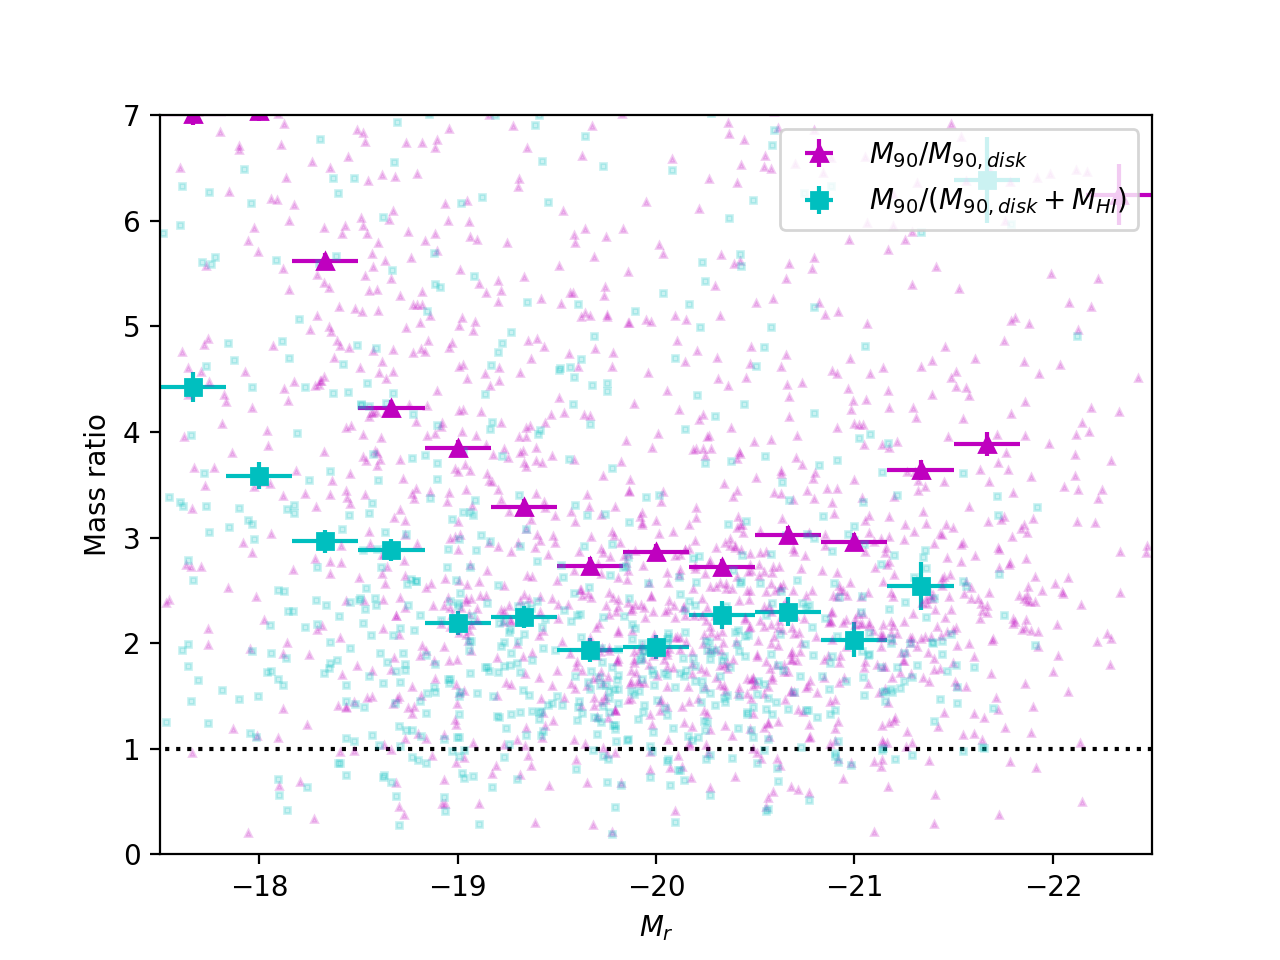

In [37]:
plt.figure()

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.hlines(1, -22.5, -17.5, colors='k', linestyle=':')

plt.plot(good_galaxies['rabsmag'], good_galaxies['M90_Mdisk_ratio'], 
         'm^', markersize=2, alpha=0.2)
plt.plot(goodHI_galaxies['rabsmag'], goodHI_galaxies['M90_MdiskHI_ratio'], 
         'cs', markersize=2, alpha=0.2)

plt.errorbar(Mr_bins + 0.5*Mr_bin_width, Mdisk_medians, 
             xerr=0.5*Mr_bin_width, yerr=Mdisk_errs, 
             c='m', fmt='^', label='$M_{90}/M_{90, disk}$')
plt.errorbar(Mr_bins + 0.5*Mr_bin_width, MdiskHI_medians, 
             xerr=0.5*Mr_bin_width, yerr=MdiskHI_errs, 
             c='c', fmt='s', label='$M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlabel('$M_r$')
plt.ylabel('Mass ratio')

plt.xlim([-17.5,-22.5])
plt.ylim([0,7])

plt.legend();
################################################################################

# Relationship between metallicity and mass ratios

In [38]:
Z_bins = np.linspace(8.5, 10.5, 13)
Z_bin_width = Z_bins[1] - Z_bins[0]

ZMdisk_medians, ZMdisk_errs = bin_median(good_galaxies, 'Z12logOH', Z_bins, 'M90_Mdisk_ratio')
ZMdiskHI_medians, ZMdiskHI_errs = bin_median(goodHI_galaxies, 'Z12logOH', Z_bins, 'M90_MdiskHI_ratio')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_7901/1303199474.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  binned_err[i] = 1/np.sqrt(sum(gal_in_bin))


<IPython.core.display.Javascript object>


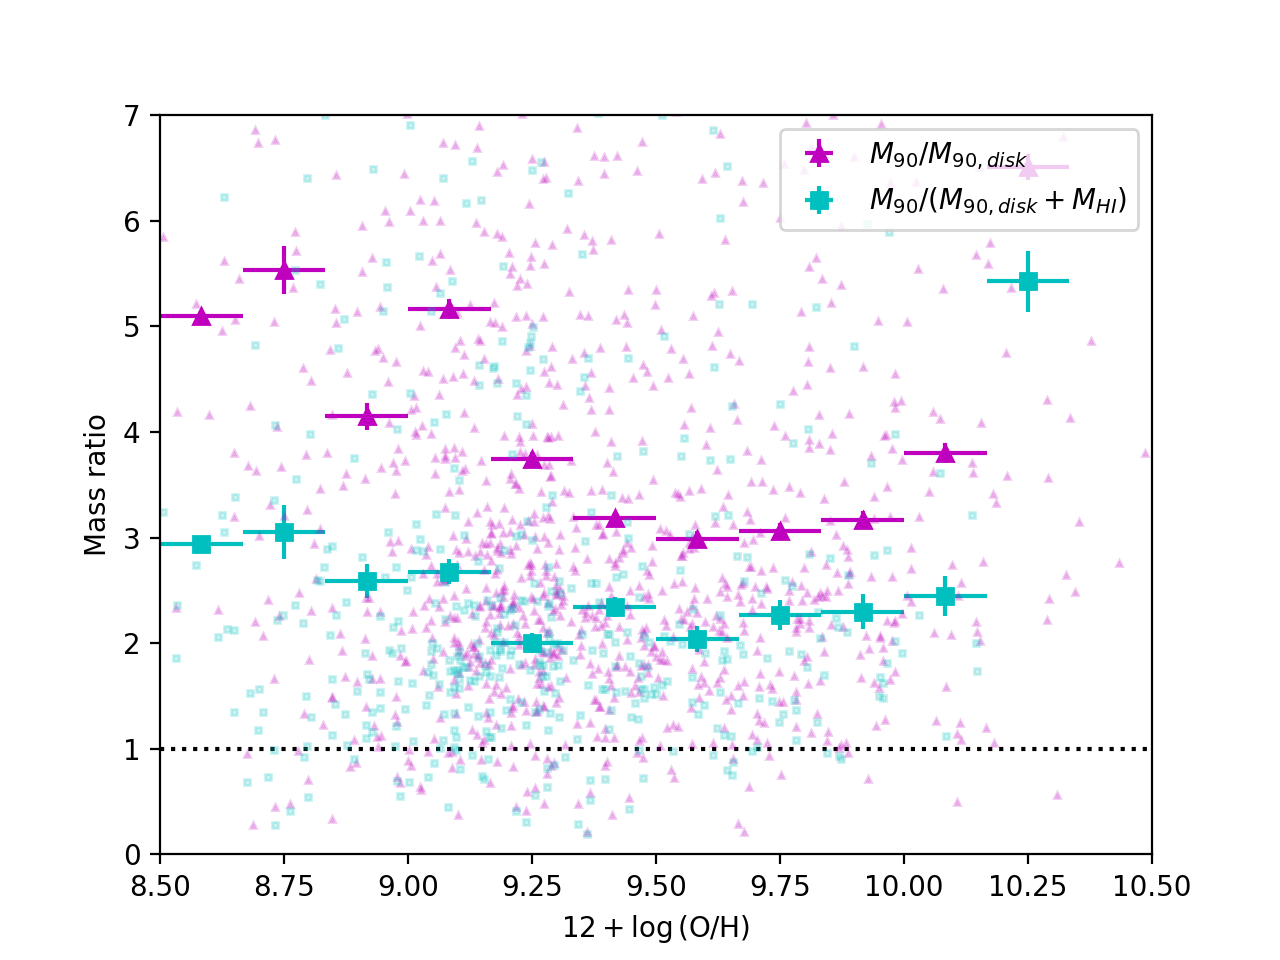

In [39]:
plt.figure()

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.hlines(1, 8.5, 10.5, colors='k', linestyle=':')

plt.plot(good_galaxies['Z12logOH'], good_galaxies['M90_Mdisk_ratio'], 
         'm^', markersize=2, alpha=0.2)
plt.plot(goodHI_galaxies['Z12logOH'], goodHI_galaxies['M90_MdiskHI_ratio'], 
         'cs', markersize=2, alpha=0.2)

plt.errorbar(Z_bins + 0.5*Z_bin_width, ZMdisk_medians, 
             xerr=0.5*Z_bin_width, yerr=ZMdisk_errs, 
             c='m', fmt='^', label='$M_{90}/M_{90, disk}$')
plt.errorbar(Z_bins + 0.5*Z_bin_width, ZMdiskHI_medians, 
             xerr=0.5*Z_bin_width, yerr=ZMdiskHI_errs, 
             c='c', fmt='s', label='$M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlabel('$12 + \log$(O/H)')
plt.ylabel('Mass ratio')

plt.xlim([8.5,10.5])
plt.ylim([0,7])

plt.legend();
################################################################################

# Relationship between $M_r$, metallicity, and mass ratio

In [40]:
def bin2D_median(data, bin1_quantity, bin2_quantity, bins1, bins2, median_quantity):
    '''
    Calculate the median value of the quantity median_quantity when the objects in 
    data are binned by bin_quanitity1 and bin_quantity2.
    
    
    PARAMETERS
    ==========
    
    data : astropy table
        Galaxy data
        
    bin1_quantity, bin2_quantity : string
        Name of columns in data by which to bin the data
        
    bins1, bins2 : ndarray of shape (n,)
        Arrays of bin edges (arrays do not need to be the same length)
        
    median_quantity : string
        Name of column in data for which to calculate the median once the data is 
        binned
        
        
    RETURNS
    =======
    
    binned_data : ndarray of shape (n,m)
        Median values of median_quantity for each bin of bin1_quantity and bin2_quantity
    '''
    
    if bin1_quantity in ['Mstar', 'NSA_Mstar']:
        bin1_indices = np.digitize(np.log10(data[bin1_quantity]), bins1)
    else:
        bin1_indices = np.digitize(data[bin1_quantity], bins1)
    
    if bin2_quantity in ['Mstar', 'NSA_Mstar']:
        bin2_indices = np.digitize(np.log10(data[bin2_quantity]), bins2)
    else:
        bin2_indices = np.digitize(data[bin2_quantity], bins2)
    
    n1_bins = len(bins1)
    n2_bins = len(bins2)
    
    binned_median = np.nan*np.ones((n1_bins, n2_bins))
    
    for i in range(n1_bins):
        for j in range(n2_bins):
            # Find galaxies in this bin
            gal_in_bin = np.logical_and(bin1_indices == i, bin2_indices == j)

            # Calculate median of galaxies in bin
            if median_quantity in ['Mstar', 'NSA_Mstar', 'Mtot']:
                binned_median[i,j] = np.log10(np.median(data[median_quantity][gal_in_bin]))
            else:
                binned_median[i,j] = np.median(data[median_quantity][gal_in_bin])
        
    return binned_median

In [41]:
Mr_bins2d = np.linspace(-22.5, -17.5, 5)
Z_bins2d = np.linspace(8.5, 10.5, 5)

M90Mdisk_median = bin2D_median(good_galaxies, 
                               'Z12logOH', 'rabsmag', 
                               Z_bins2d, Mr_bins2d, 
                               'M90_Mdisk_ratio')

M90MHI_median = bin2D_median(goodHI_galaxies, 
                             'Z12logOH', 'rabsmag', 
                             Z_bins2d, Mr_bins2d, 
                             'M90_MdiskHI_ratio')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


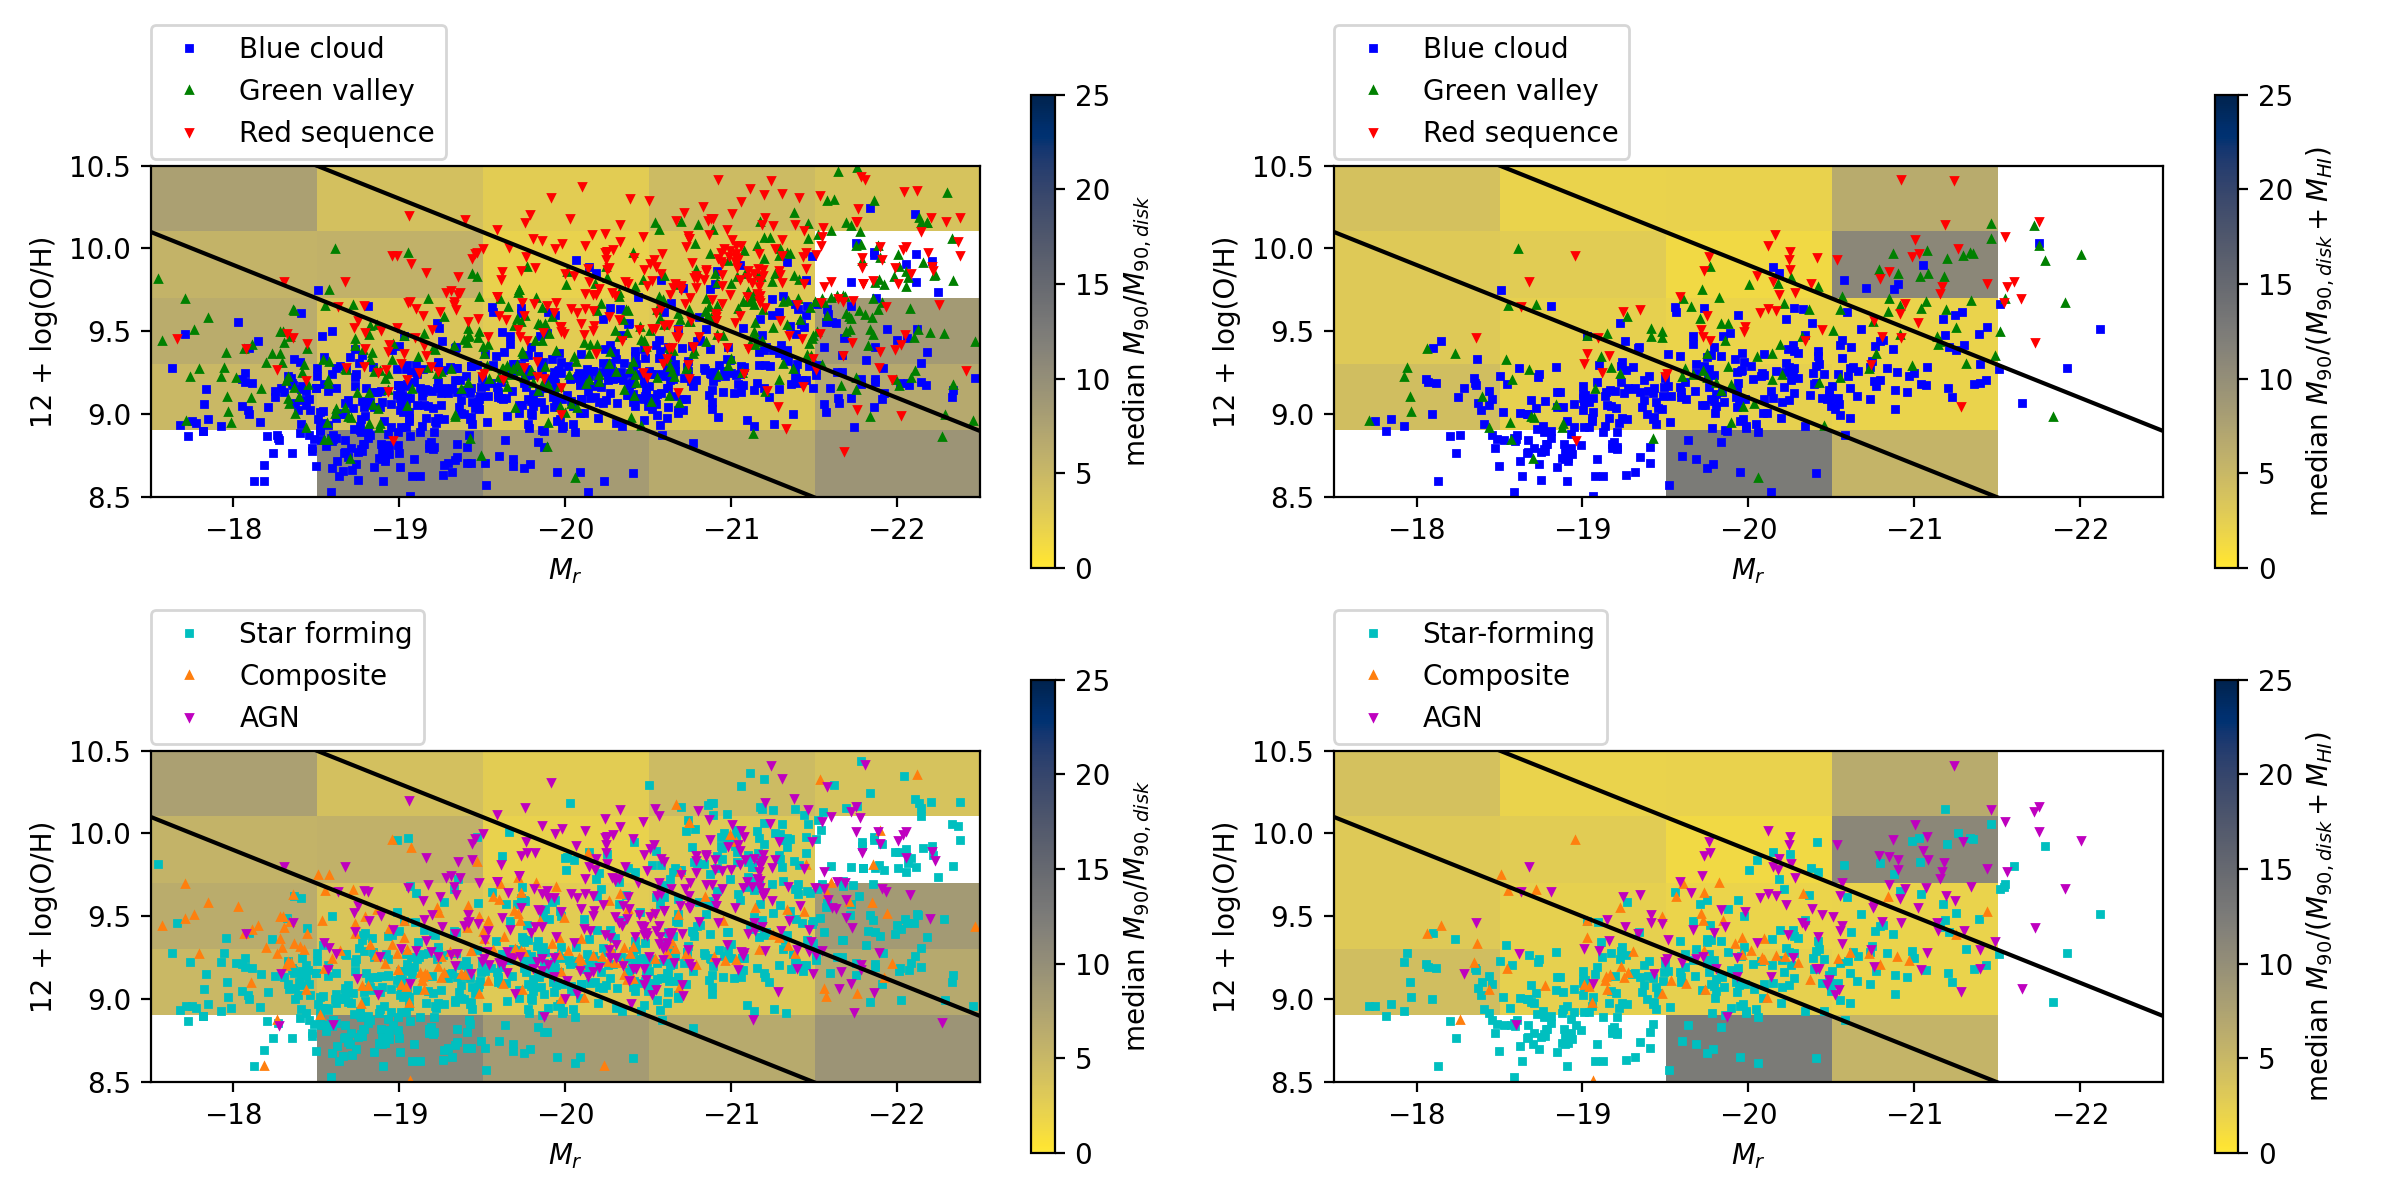

In [42]:
plt.figure(figsize=(12,6))

################################################################################
# Mtot/M*
#-------------------------------------------------------------------------------
plt.subplot(221)

plt.imshow(M90Mdisk_median, cmap='cividis_r', vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], Z_bins2d[-1], Z_bins2d[0]))

plt.plot(BC['rabsmag'], BC['Z12logOH'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV['rabsmag'], GV['Z12logOH'], 'g^', markersize=2, label='Green valley')
plt.plot(RS['rabsmag'], RS['Z12logOH'], 'rv', markersize=2, label='Red sequence')

Mr = np.linspace(-23,-17,5)
plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')

plt.xlabel('$M_r$')
plt.ylabel('12 + log(O/H)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(Z_bins2d[0], Z_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI)
#-------------------------------------------------------------------------------
plt.subplot(222)

plt.imshow(M90MHI_median, cmap='cividis_r', vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], Z_bins2d[-1], Z_bins2d[0]))

plt.plot(BC_HI['rabsmag'], BC_HI['Z12logOH'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV_HI['rabsmag'], GV_HI['Z12logOH'], 'g^', markersize=2, label='Green valley')
plt.plot(RS_HI['rabsmag'], RS_HI['Z12logOH'], 'rv', markersize=2, label='Red sequence')

plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')

plt.xlabel('$M_r$')
plt.ylabel('12 + log(O/H)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(Z_bins2d[0], Z_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/M* colored by BPT
#-------------------------------------------------------------------------------
plt.subplot(223)

plt.imshow(M90Mdisk_median, cmap='cividis_r', vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], Z_bins2d[-1], Z_bins2d[0]))

plt.plot(SF['rabsmag'], SF['Z12logOH'], 'cs', markersize=2, label='Star forming')
plt.plot(comp['rabsmag'], comp['Z12logOH'], '^', c='tab:orange', markersize=2, label='Composite')
plt.plot(AGN['rabsmag'], AGN['Z12logOH'], 'mv', markersize=2, label='AGN')

Mr = np.linspace(-23,-17,5)
plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')

plt.xlabel('$M_r$')
plt.ylabel('12 + log(O/H)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(Z_bins2d[0], Z_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI) colored by BPT
#-------------------------------------------------------------------------------
plt.subplot(224)

plt.imshow(M90MHI_median, cmap='cividis_r', vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], Z_bins2d[-1], Z_bins2d[0]))

plt.plot(SF_HI['rabsmag'], SF_HI['Z12logOH'], 'cs', markersize=2, label='Star-forming')
plt.plot(comp_HI['rabsmag'], comp_HI['Z12logOH'], '^', c='tab:orange', markersize=2, label='Composite')
plt.plot(AGN_HI['rabsmag'], AGN_HI['Z12logOH'], 'mv', markersize=2, label='AGN')

plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')

plt.xlabel('$M_r$')
plt.ylabel('12 + log(O/H)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(Z_bins2d[0], Z_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################

plt.tight_layout();

# Relationship between $M_r$, (s)SFR, and mass ratio

In [43]:
Mr_bins2d = np.arange(-22.5, -16.5, 1)
SFR_bins2d = np.arange(-2, 2, 1)
sSFR_bins2d = np.arange(-13, -8, 1)

In [44]:
M90Mdisk_median_SFR = bin2D_median(good_galaxies, 
                                   'SFR', 'rabsmag', 
                                   SFR_bins2d, Mr_bins2d, 
                                   'M90_Mdisk_ratio')

M90MHI_median_SFR = bin2D_median(goodHI_galaxies, 
                                 'SFR', 'rabsmag', 
                                 SFR_bins2d, Mr_bins2d, 
                                 'M90_MdiskHI_ratio')

M90Mdisk_median_sSFR = bin2D_median(good_galaxies, 
                                   'sSFR', 'rabsmag', 
                                   sSFR_bins2d, Mr_bins2d, 
                                   'M90_Mdisk_ratio')

M90MHI_median_sSFR = bin2D_median(goodHI_galaxies, 
                                 'sSFR', 'rabsmag', 
                                 sSFR_bins2d, Mr_bins2d, 
                                 'M90_MdiskHI_ratio')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
# SFR
M90Mdisk_median_SFR_SF = bin2D_median(SF, 
                                      'SFR', 'rabsmag', 
                                      SFR_bins2d, Mr_bins2d, 
                                      'M90_Mdisk_ratio')

M90MHI_median_SFR_SF = bin2D_median(SF_HI, 
                                    'SFR', 'rabsmag', 
                                    SFR_bins2d, Mr_bins2d, 
                                    'M90_MdiskHI_ratio')

M90Mdisk_median_SFR_comp = bin2D_median(comp, 
                                        'SFR', 'rabsmag', 
                                        SFR_bins2d, Mr_bins2d, 
                                        'M90_Mdisk_ratio')

M90MHI_median_SFR_comp = bin2D_median(comp_HI, 
                                      'SFR', 'rabsmag', 
                                      SFR_bins2d, Mr_bins2d, 
                                      'M90_MdiskHI_ratio')

M90Mdisk_median_SFR_AGN = bin2D_median(AGN, 
                                       'SFR', 'rabsmag', 
                                       SFR_bins2d, Mr_bins2d, 
                                       'M90_Mdisk_ratio')

M90MHI_median_SFR_AGN = bin2D_median(AGN_HI, 
                                     'SFR', 'rabsmag', 
                                     SFR_bins2d, Mr_bins2d, 
                                     'M90_MdiskHI_ratio')

# sSFR
M90Mdisk_median_sSFR_SF = bin2D_median(SF, 
                                       'sSFR', 'rabsmag', 
                                       sSFR_bins2d, Mr_bins2d, 
                                       'M90_Mdisk_ratio')

M90MHI_median_sSFR_SF = bin2D_median(SF_HI, 
                                     'sSFR', 'rabsmag', 
                                     sSFR_bins2d, Mr_bins2d, 
                                     'M90_MdiskHI_ratio')

M90Mdisk_median_sSFR_comp = bin2D_median(comp, 
                                         'sSFR', 'rabsmag', 
                                         sSFR_bins2d, Mr_bins2d, 
                                         'M90_Mdisk_ratio')

M90MHI_median_sSFR_comp = bin2D_median(comp_HI, 
                                       'sSFR', 'rabsmag', 
                                       sSFR_bins2d, Mr_bins2d, 
                                       'M90_MdiskHI_ratio')

M90Mdisk_median_sSFR_AGN = bin2D_median(AGN, 
                                        'sSFR', 'rabsmag', 
                                        sSFR_bins2d, Mr_bins2d, 
                                        'M90_Mdisk_ratio')

M90MHI_median_sSFR_AGN = bin2D_median(AGN_HI, 
                                      'sSFR', 'rabsmag', 
                                      sSFR_bins2d, Mr_bins2d, 
                                      'M90_MdiskHI_ratio')

<IPython.core.display.Javascript object>


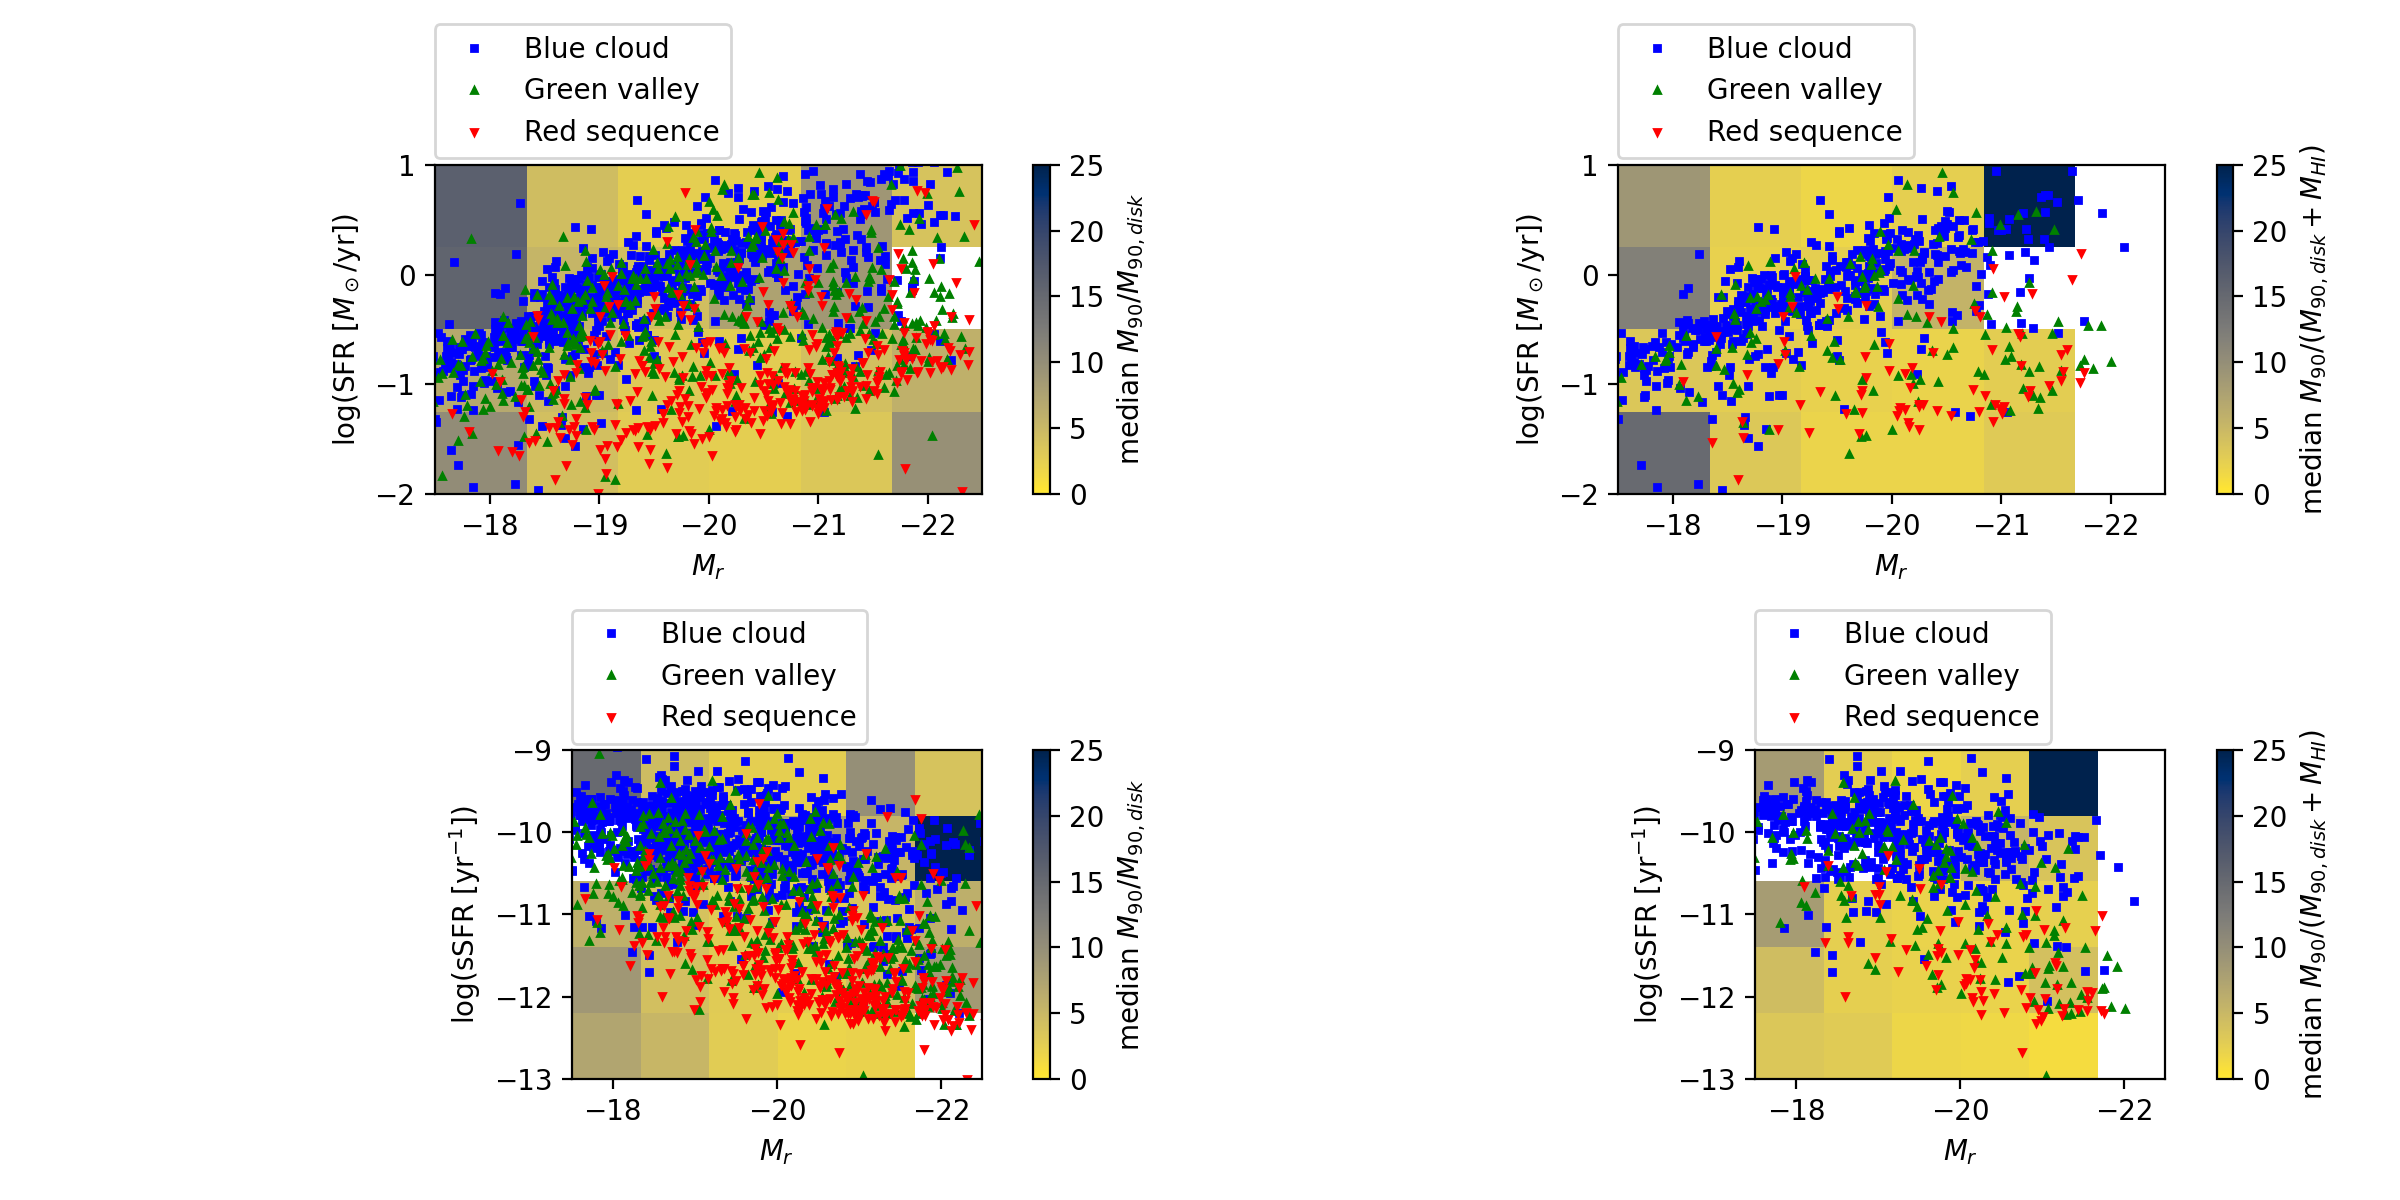

In [46]:
plt.figure(figsize=(12,6))

################################################################################
# Mtot/M*
#-------------------------------------------------------------------------------
plt.subplot(221)

plt.imshow(M90Mdisk_median_SFR, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], SFR_bins2d[-1], SFR_bins2d[0]))

plt.plot(BC['rabsmag'], BC['SFR'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV['rabsmag'], GV['SFR'], 'g^', markersize=2, label='Green valley')
plt.plot(RS['rabsmag'], RS['SFR'], 'rv', markersize=2, label='Red sequence')

'''
Mr = np.linspace(-23,-17,5)
plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')
''';

plt.xlabel('$M_r$')
plt.ylabel('log(SFR [$M_\odot$/yr])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(SFR_bins2d[0], SFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI)
#-------------------------------------------------------------------------------
plt.subplot(222)

plt.imshow(M90MHI_median_SFR, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], SFR_bins2d[-1], SFR_bins2d[0]))

plt.plot(BC_HI['rabsmag'], BC_HI['SFR'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV_HI['rabsmag'], GV_HI['SFR'], 'g^', markersize=2, label='Green valley')
plt.plot(RS_HI['rabsmag'], RS_HI['SFR'], 'rv', markersize=2, label='Red sequence')

'''
plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')
''';

plt.xlabel('$M_r$')
plt.ylabel('log(SFR [$M_\odot$/yr])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(SFR_bins2d[0], SFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/M* for sSFR
#-------------------------------------------------------------------------------
plt.subplot(223)

plt.imshow(M90Mdisk_median_sSFR, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], sSFR_bins2d[-1], sSFR_bins2d[0]))

plt.plot(BC['rabsmag'], BC['sSFR'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV['rabsmag'], GV['sSFR'], 'g^', markersize=2, label='Green valley')
plt.plot(RS['rabsmag'], RS['sSFR'], 'rv', markersize=2, label='Red sequence')

'''
Mr = np.linspace(-23,-17,5)
plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')
''';

plt.xlabel('$M_r$')
plt.ylabel('log(sSFR [yr$^{-1}$])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(sSFR_bins2d[0], sSFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI) for sSFR
#-------------------------------------------------------------------------------
plt.subplot(224)

plt.imshow(M90MHI_median_sSFR, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], sSFR_bins2d[-1], sSFR_bins2d[0]))

plt.plot(BC_HI['rabsmag'], BC_HI['sSFR'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV_HI['rabsmag'], GV_HI['sSFR'], 'g^', markersize=2, label='Green valley')
plt.plot(RS_HI['rabsmag'], RS_HI['sSFR'], 'rv', markersize=2, label='Red sequence')

'''
plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')
''';

plt.xlabel('$M_r$')
plt.ylabel('log(sSFR [yr$^{-1}$])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(sSFR_bins2d[0], sSFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################

plt.tight_layout();

<IPython.core.display.Javascript object>


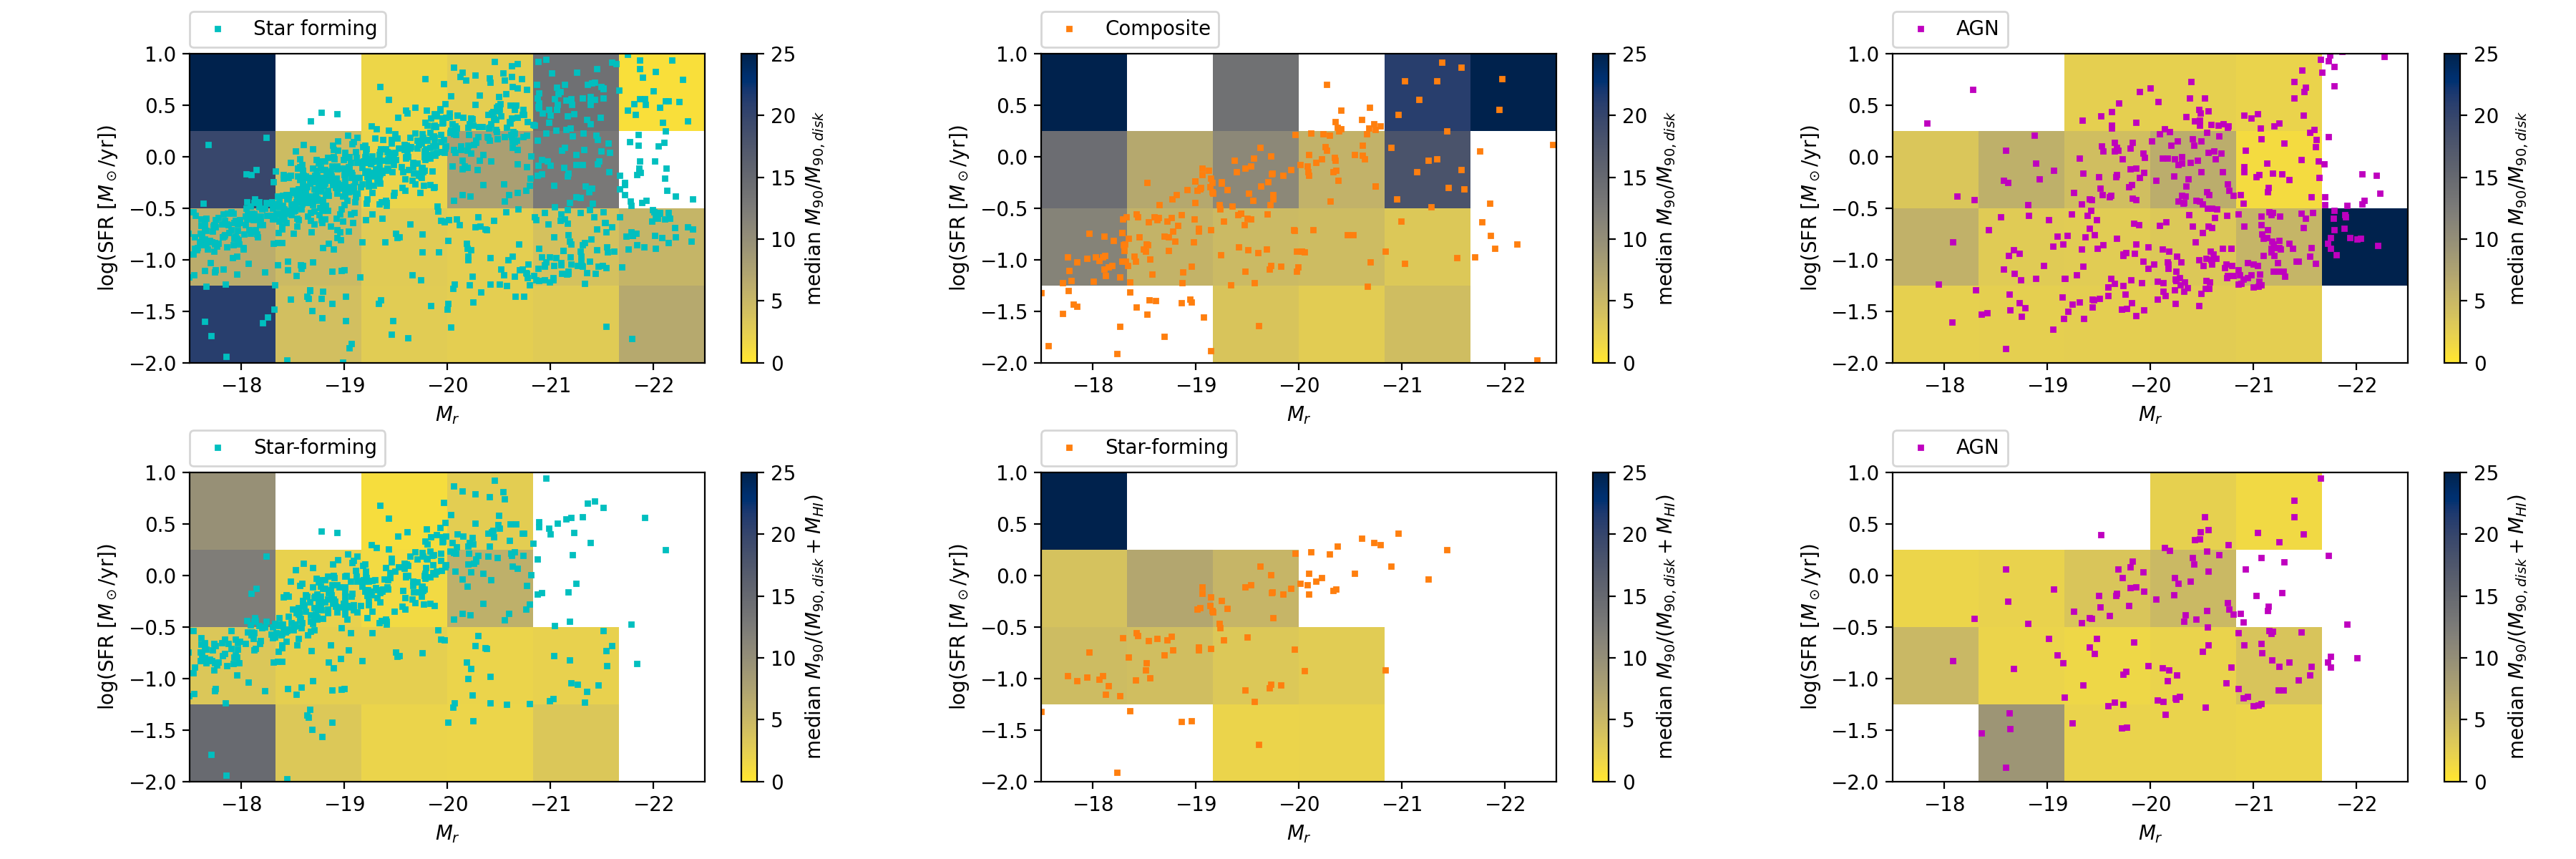

In [47]:
plt.figure(figsize=(18,6))

################################################################################
# Mtot/M*
#-------------------------------------------------------------------------------
plt.subplot(231)

plt.imshow(M90Mdisk_median_SFR_SF, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], SFR_bins2d[-1], SFR_bins2d[0]))

plt.plot(SF['rabsmag'], SF['SFR'], 'cs', markersize=2, label='Star forming')

plt.xlabel('$M_r$')
plt.ylabel('log(SFR [$M_\odot$/yr])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(SFR_bins2d[0], SFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI)
#-------------------------------------------------------------------------------
plt.subplot(234)

plt.imshow(M90MHI_median_SFR_SF, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], SFR_bins2d[-1], SFR_bins2d[0]))

plt.plot(SF_HI['rabsmag'], SF_HI['SFR'], 'cs', markersize=2, label='Star-forming')

plt.xlabel('$M_r$')
plt.ylabel('log(SFR [$M_\odot$/yr])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(SFR_bins2d[0], SFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/M* for composite galaxies
#-------------------------------------------------------------------------------
plt.subplot(232)

plt.imshow(M90Mdisk_median_SFR_comp, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], SFR_bins2d[-1], SFR_bins2d[0]))

plt.plot(comp['rabsmag'], comp['SFR'], 's', c='tab:orange', markersize=2, 
         label='Composite')

plt.xlabel('$M_r$')
plt.ylabel('log(SFR [$M_\odot$/yr])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(SFR_bins2d[0], SFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI) for composite galaxies
#-------------------------------------------------------------------------------
plt.subplot(235)

plt.imshow(M90MHI_median_SFR_comp, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], SFR_bins2d[-1], SFR_bins2d[0]))

plt.plot(comp_HI['rabsmag'], comp_HI['SFR'], 's', c='tab:orange', markersize=2, 
         label='Star-forming')

plt.xlabel('$M_r$')
plt.ylabel('log(SFR [$M_\odot$/yr])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(SFR_bins2d[0], SFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/M* for AGN
#-------------------------------------------------------------------------------
plt.subplot(233)

plt.imshow(M90Mdisk_median_SFR_AGN, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], SFR_bins2d[-1], SFR_bins2d[0]))

plt.plot(AGN['rabsmag'], AGN['SFR'], 'ms', markersize=2, label='AGN')

plt.xlabel('$M_r$')
plt.ylabel('log(SFR [$M_\odot$/yr])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(SFR_bins2d[0], SFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI) for AGN
#-------------------------------------------------------------------------------
plt.subplot(236)

plt.imshow(M90MHI_median_SFR_AGN, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], SFR_bins2d[-1], SFR_bins2d[0]))

plt.plot(AGN_HI['rabsmag'], AGN_HI['SFR'], 'ms', markersize=2, label='AGN')

plt.xlabel('$M_r$')
plt.ylabel('log(SFR [$M_\odot$/yr])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(SFR_bins2d[0], SFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################

plt.tight_layout();

<IPython.core.display.Javascript object>


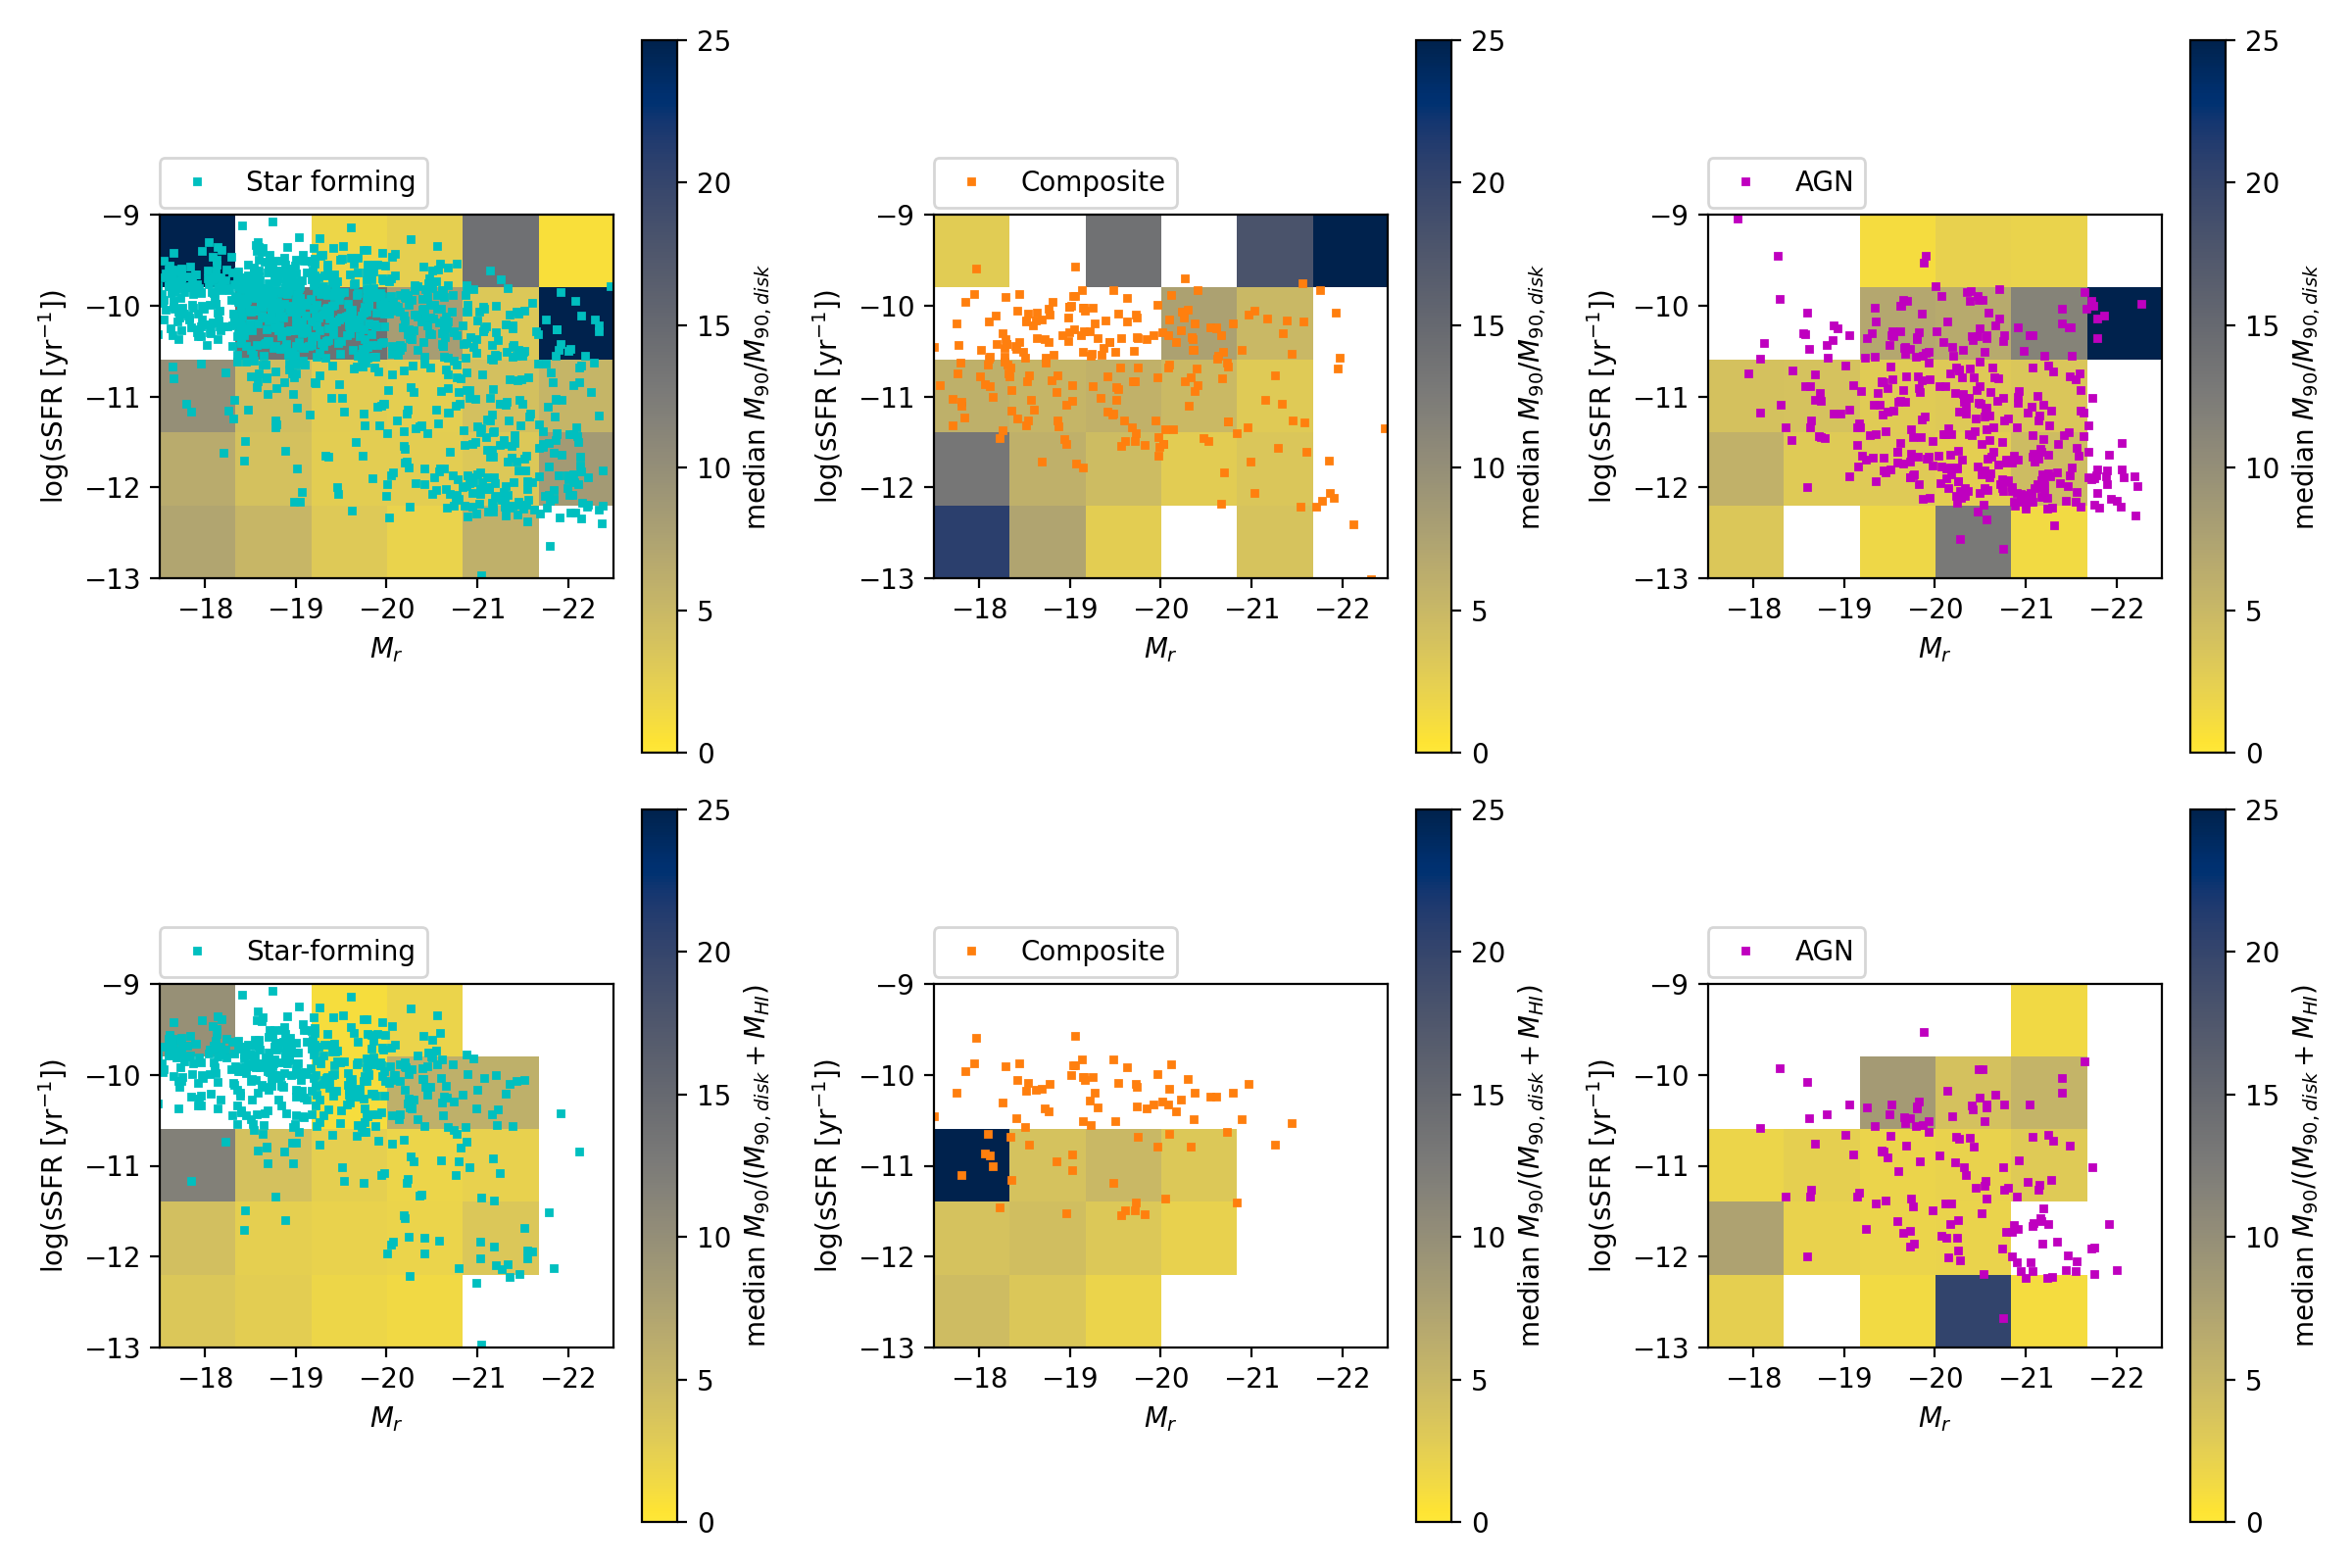

In [48]:
plt.figure(figsize=(12,8))

################################################################################
# Mtot/M* for star-forming galaxies
#-------------------------------------------------------------------------------
plt.subplot(231)

plt.imshow(M90Mdisk_median_sSFR_SF, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], sSFR_bins2d[-1], sSFR_bins2d[0]))

plt.plot(SF['rabsmag'], SF['sSFR'], 'cs', markersize=2, label='Star forming')

plt.xlabel('$M_r$')
plt.ylabel('log(sSFR [yr$^{-1}$])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(sSFR_bins2d[0], sSFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI) for star-forming galaxies
#-------------------------------------------------------------------------------
plt.subplot(234)

plt.imshow(M90MHI_median_sSFR_SF, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], sSFR_bins2d[-1], sSFR_bins2d[0]))

plt.plot(SF_HI['rabsmag'], SF_HI['sSFR'], 'cs', markersize=2, label='Star-forming')

plt.xlabel('$M_r$')
plt.ylabel('log(sSFR [yr$^{-1}$])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(sSFR_bins2d[0], sSFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/M* for composite galaxies
#-------------------------------------------------------------------------------
plt.subplot(232)

plt.imshow(M90Mdisk_median_sSFR_comp, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], sSFR_bins2d[-1], sSFR_bins2d[0]))

plt.plot(comp['rabsmag'], comp['sSFR'], 's', c='tab:orange', markersize=2, 
         label='Composite')

plt.xlabel('$M_r$')
plt.ylabel('log(sSFR [yr$^{-1}$])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(sSFR_bins2d[0], sSFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI) for composite galaxies
#-------------------------------------------------------------------------------
plt.subplot(235)

plt.imshow(M90MHI_median_sSFR_comp, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], sSFR_bins2d[-1], sSFR_bins2d[0]))

plt.plot(comp_HI['rabsmag'], comp_HI['sSFR'], 's', c='tab:orange', markersize=2, 
         label='Composite')

plt.xlabel('$M_r$')
plt.ylabel('log(sSFR [yr$^{-1}$])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(sSFR_bins2d[0], sSFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/M* for AGN
#-------------------------------------------------------------------------------
plt.subplot(233)

plt.imshow(M90Mdisk_median_sSFR_AGN, 
           cmap='cividis_r', #'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], sSFR_bins2d[-1], sSFR_bins2d[0]))

plt.plot(AGN['rabsmag'], AGN['sSFR'], 'ms', markersize=2, label='AGN')

plt.xlabel('$M_r$')
plt.ylabel('log(sSFR [yr$^{-1}$])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(sSFR_bins2d[0], sSFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI) for AGN
#-------------------------------------------------------------------------------
plt.subplot(236)

plt.imshow(M90MHI_median_sSFR_AGN, 
           cmap='cividis_r',#'gray_r', 
           vmin=0, vmax=25, origin='lower', 
           extent=(Mr_bins2d[0], Mr_bins2d[-1], sSFR_bins2d[-1], sSFR_bins2d[0]))

plt.plot(AGN_HI['rabsmag'], AGN_HI['sSFR'], 'ms', markersize=2, label='AGN')

plt.xlabel('$M_r$')
plt.ylabel('log(sSFR [yr$^{-1}$])')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(sSFR_bins2d[0], sSFR_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################

plt.tight_layout();

In [49]:
good_galaxies

<Table length=1988>
MaNGA_plate MaNGA_IFU NSA_plate ... M90_MdiskHI_ratio       M90_vis      
   int64      int64     int64   ...      float64            float64      
----------- --------- --------- ... ------------------ ------------------
       8465      1901      1281 ...  9.370251187734311 10.270850556238864
       8249      3702       899 ... 0.5526932673724017 10.174778419165506
       9027      9101      1420 ... 1.7171492983784908  10.31818514955382
       8247     12705      1200 ...  6.689524536494902 10.195344267160051
       9027     12703      1420 ... 20.032635933217133  10.64561005552243
       9027      3701      1420 ...                nan                nan
        ...       ...       ... ...                ...                ...
       8548      6103       622 ... 1.0882452512737864  9.833909095193581
       9029      3702       816 ... 29.393133389014725 10.649926764012005
       9031      3704      1169 ...                nan                nan
       8134     12704      3665 ...                nan                nan
       9024     12704      1647 ...                nan                nan
       8997      1901       879 ...                nan                nan
       8133      6101      1865 ...                nan                nan